In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime

#Statistics
# Statistics
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from dateutil.parser import parse 
import pickle

# READ CSV AND DESCRIPTION OF SERIES


In [3]:
#DIFFICULTY RIBBON
difficulty_ribbon = pd.read_csv("data/bitcoin-difficulty-ribbon.csv")

difficulty_ribbon["Difficulty Ribbon/t"] = difficulty_ribbon["Difficulty Ribbon/t"].str.rstrip("T00:00:00.000Z")
difficulty_ribbon["Difficulty Ribbon/t"] = pd.to_datetime(difficulty_ribbon["Difficulty Ribbon/t"])
difficulty_ribbon = difficulty_ribbon.sort_values(by='Difficulty Ribbon/t')
difficulty_ribbon = difficulty_ribbon.rename(columns={'Difficulty Ribbon/t': 'Timestamp'})
difficulty_ribbon.head()

################ RIMUOVO DATE 2009 E 2022
difficulty_ribbon = difficulty_ribbon[~(difficulty_ribbon['Timestamp'] < '2010-01-01')]
difficulty_ribbon = difficulty_ribbon[~(difficulty_ribbon['Timestamp'] > '2021-12-31')]

#fixing index
difficulty_ribbon.reset_index(drop=True, inplace=True)


#Description
print(difficulty_ribbon)
print("\nShape is:", difficulty_ribbon.shape)
print("\nSummary of the dataset:")
difficulty_ribbon.describe()
print("\nAre there null values?")
difficulty_ribbon.isna().sum()

      Timestamp  Difficulty Ribbon/o/ma128  Difficulty Ribbon/o/ma14  \
0    2010-01-01               4.313379e+09              4.463299e+09   
1    2010-01-01               4.368612e+09              4.968294e+09   
2    2010-01-02               4.319516e+09              4.519409e+09   
3    2010-01-02               4.470974e+09              5.455289e+09   
4    2010-01-03               4.581221e+09              5.677286e+09   
...         ...                        ...                       ...   
4378 2021-12-26               8.835174e+22              1.039652e+23   
4379 2021-12-27               8.864421e+22              1.039889e+23   
4380 2021-12-28               8.893667e+22              1.040125e+23   
4381 2021-12-29               8.922914e+22              1.040361e+23   
4382 2021-12-31               8.974499e+22              1.040834e+23   

      Difficulty Ribbon/o/ma200  Difficulty Ribbon/o/ma25  \
0                  4.306751e+09              4.389233e+09   
1            

Timestamp                    0
Difficulty Ribbon/o/ma128    0
Difficulty Ribbon/o/ma14     0
Difficulty Ribbon/o/ma200    0
Difficulty Ribbon/o/ma25     0
Difficulty Ribbon/o/ma40     0
Difficulty Ribbon/o/ma60     0
Difficulty Ribbon/o/ma9      0
Difficulty Ribbon/o/ma90     0
dtype: int64

In [4]:
# Extract years
difficulty_ribbon['year'] = [d.year for d in difficulty_ribbon["Timestamp"]]

In [5]:
difficulty_ribbon.year.unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021])

In [6]:
difficulty_ribbon.year.value_counts()

2012    366
2016    366
2020    366
2010    365
2011    365
2013    365
2014    365
2015    365
2017    365
2018    365
2019    365
2021    365
Name: year, dtype: int64

# VISUALIZATION

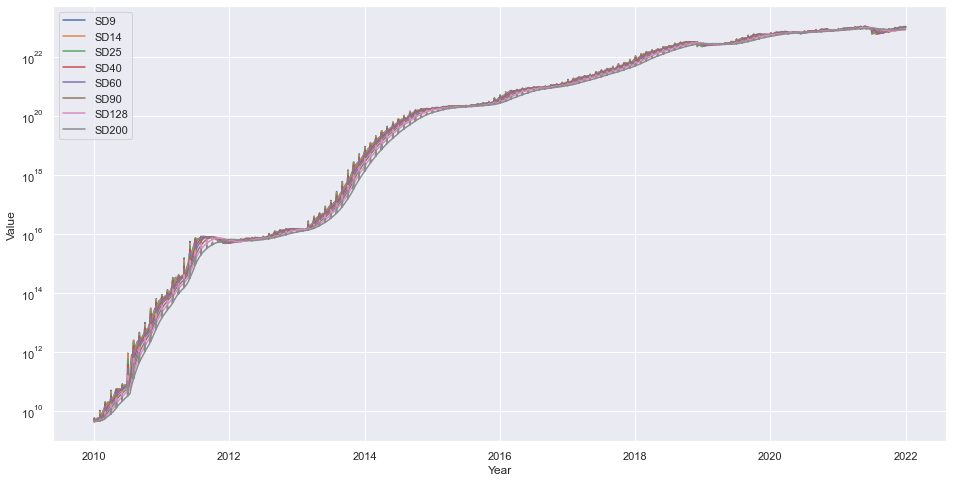

In [93]:
plt.figure(figsize=(16,8))
plt.plot(difficulty_ribbon["Timestamp"], difficulty_ribbon["Difficulty Ribbon/o/ma9"])
plt.plot(difficulty_ribbon["Timestamp"], difficulty_ribbon["Difficulty Ribbon/o/ma14"])
plt.plot(difficulty_ribbon["Timestamp"], difficulty_ribbon["Difficulty Ribbon/o/ma25"])
plt.plot(difficulty_ribbon["Timestamp"], difficulty_ribbon["Difficulty Ribbon/o/ma40"])
plt.plot(difficulty_ribbon["Timestamp"], difficulty_ribbon["Difficulty Ribbon/o/ma60"])
plt.plot(difficulty_ribbon["Timestamp"], difficulty_ribbon["Difficulty Ribbon/o/ma90"])
plt.plot(difficulty_ribbon["Timestamp"], difficulty_ribbon["Difficulty Ribbon/o/ma128"])
plt.plot(difficulty_ribbon["Timestamp"], difficulty_ribbon["Difficulty Ribbon/o/ma200"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
plt.yscale('log') 
plt.legend(['SD9', 'SD14', 'SD25', 'SD40', 'SD60', 'SD90', 'SD128', 'SD200'])
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


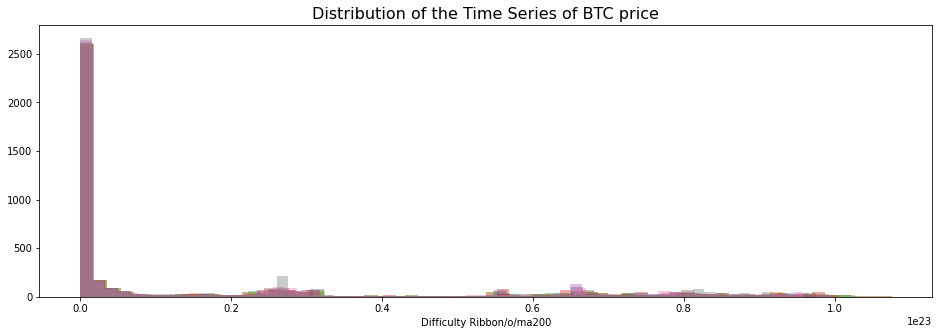

In [9]:
plt.figure(figsize=(16,5))
sns.distplot(difficulty_ribbon["Difficulty Ribbon/o/ma9"], kde = False, bins = 60)
sns.distplot(difficulty_ribbon["Difficulty Ribbon/o/ma14"], kde = False, bins = 60)
sns.distplot(difficulty_ribbon["Difficulty Ribbon/o/ma25"], kde = False, bins = 60)
sns.distplot(difficulty_ribbon["Difficulty Ribbon/o/ma40"], kde = False, bins = 60)
sns.distplot(difficulty_ribbon["Difficulty Ribbon/o/ma60"], kde = False, bins = 60)
sns.distplot(difficulty_ribbon["Difficulty Ribbon/o/ma90"], kde = False, bins = 60)
sns.distplot(difficulty_ribbon["Difficulty Ribbon/o/ma128"], kde = False, bins = 60)
sns.distplot(difficulty_ribbon["Difficulty Ribbon/o/ma200"], kde = False, bins = 60)
plt.title('Distribution of the Time Series of BTC price', fontsize=16)
plt.show()

#### Shorter time series
Same as market price

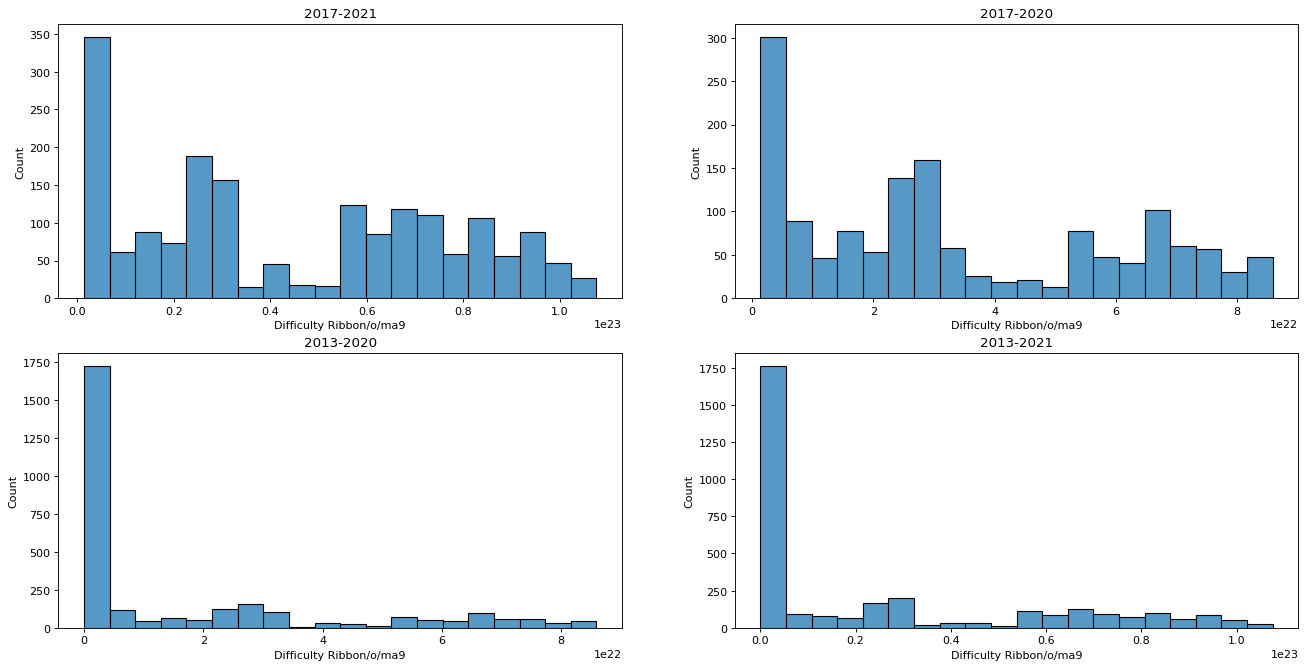

In [17]:
difficulty_ribbon["Difficulty Ribbon/o/ma9"][difficulty_ribbon["Timestamp"].dt.year == 2014].mean()
difficultyh = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2016) & (difficulty_ribbon["Timestamp"].dt.year < 2022),:]
difficultyn = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2016) & (difficulty_ribbon["Timestamp"].dt.year < 2021),:]
difficultynh = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2012) & (difficulty_ribbon["Timestamp"].dt.year < 2021),:]
difficultyf = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2012) & (difficulty_ribbon["Timestamp"].dt.year < 2022),:]

fig, axes = plt.subplots(2, 2, figsize=(20,10), dpi= 80)
sns.histplot(difficultyh["Difficulty Ribbon/o/ma9"], ax=axes[0,0],bins = 20)
sns.histplot(difficultyn["Difficulty Ribbon/o/ma9"], ax=axes[0,1],bins = 20)
sns.histplot(difficultynh["Difficulty Ribbon/o/ma9"], ax=axes[1,0],bins = 20)
sns.histplot(difficultyf["Difficulty Ribbon/o/ma9"], ax=axes[1,1],bins = 20)
axes[0,0].title.set_text('2017-2021')
axes[0,1].title.set_text('2017-2020')
axes[1,0].title.set_text('2013-2020')
axes[1,1].title.set_text('2013-2021')

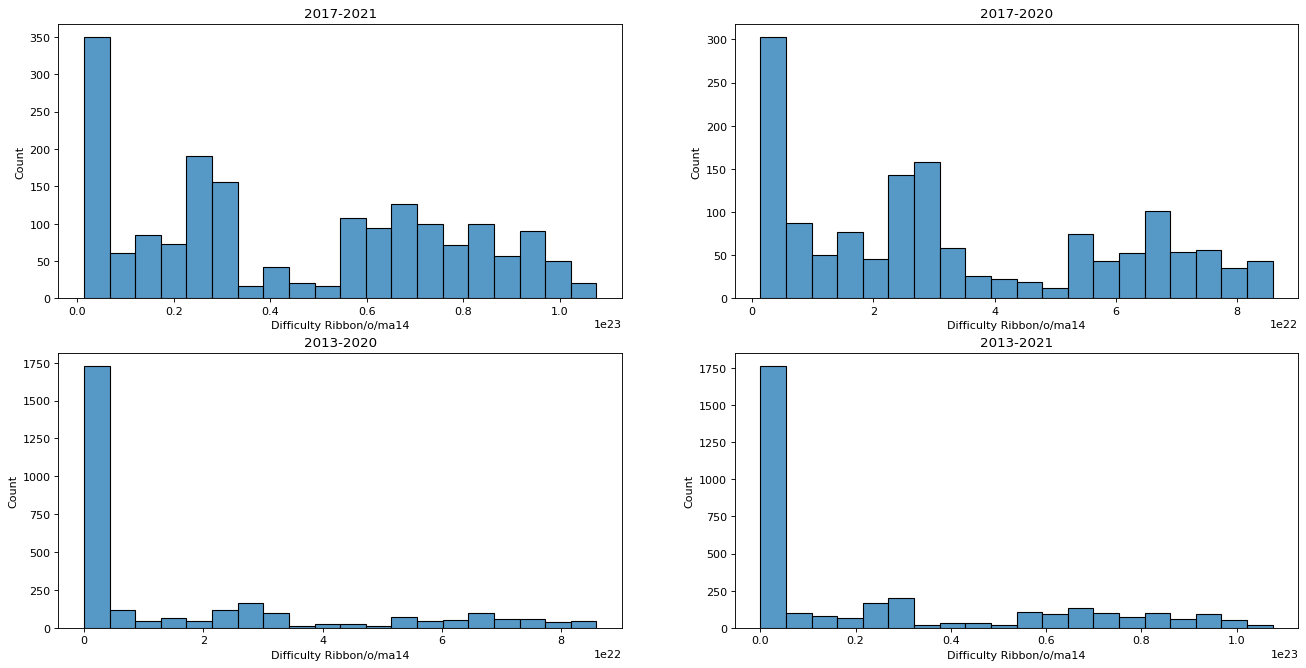

In [15]:
difficulty_ribbon["Difficulty Ribbon/o/ma14"][difficulty_ribbon["Timestamp"].dt.year == 2014].mean()
difficultyh = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2016) & (difficulty_ribbon["Timestamp"].dt.year < 2022),:]
difficultyn = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2016) & (difficulty_ribbon["Timestamp"].dt.year < 2021),:]
difficultynh = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2012) & (difficulty_ribbon["Timestamp"].dt.year < 2021),:]
difficultyf = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2012) & (difficulty_ribbon["Timestamp"].dt.year < 2022),:]

fig, axes = plt.subplots(2, 2, figsize=(20,10), dpi= 80)
sns.histplot(difficultyh["Difficulty Ribbon/o/ma14"], ax=axes[0,0],bins = 20)
sns.histplot(difficultyn["Difficulty Ribbon/o/ma14"], ax=axes[0,1],bins = 20)
sns.histplot(difficultynh["Difficulty Ribbon/o/ma14"], ax=axes[1,0],bins = 20)
sns.histplot(difficultyf["Difficulty Ribbon/o/ma14"], ax=axes[1,1],bins = 20)
axes[0,0].title.set_text('2017-2021')
axes[0,1].title.set_text('2017-2020')
axes[1,0].title.set_text('2013-2020')
axes[1,1].title.set_text('2013-2021')

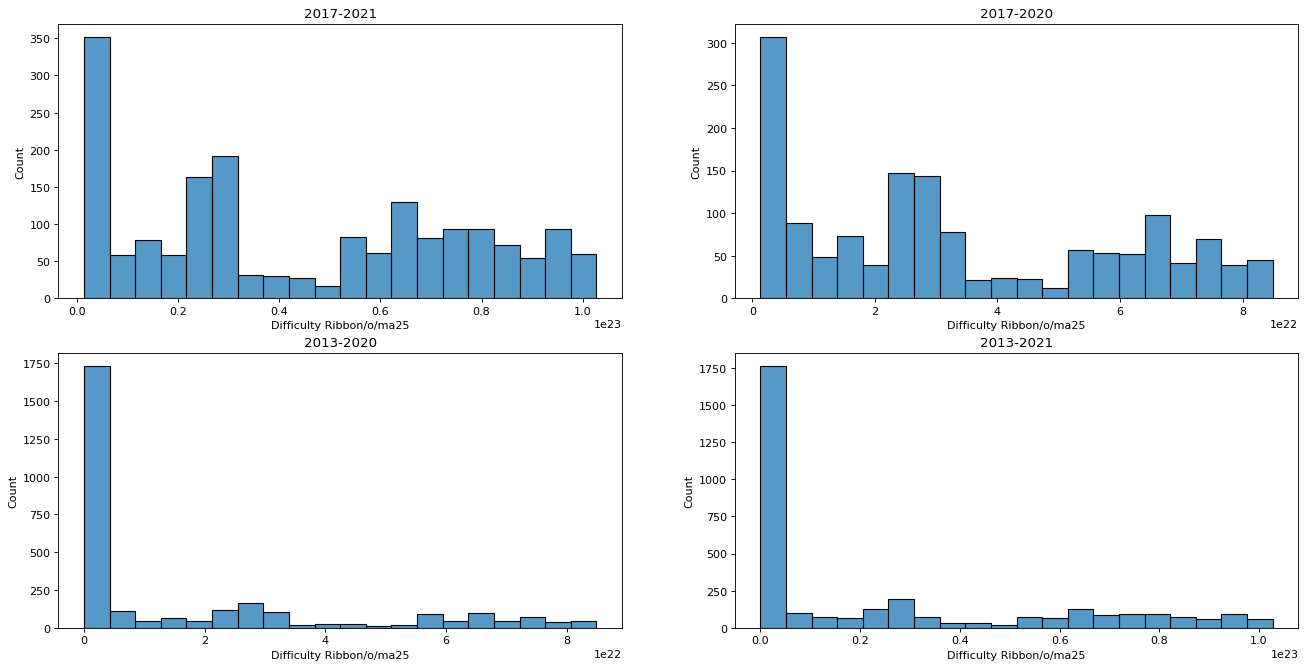

In [16]:
difficulty_ribbon["Difficulty Ribbon/o/ma25"][difficulty_ribbon["Timestamp"].dt.year == 2014].mean()
difficultyh = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2016) & (difficulty_ribbon["Timestamp"].dt.year < 2022),:]
difficultyn = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2016) & (difficulty_ribbon["Timestamp"].dt.year < 2021),:]
difficultynh = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2012) & (difficulty_ribbon["Timestamp"].dt.year < 2021),:]
difficultyf = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2012) & (difficulty_ribbon["Timestamp"].dt.year < 2022),:]

fig, axes = plt.subplots(2, 2, figsize=(20,10), dpi= 80)
sns.histplot(difficultyh["Difficulty Ribbon/o/ma25"], ax=axes[0,0],bins = 20)
sns.histplot(difficultyn["Difficulty Ribbon/o/ma25"], ax=axes[0,1],bins = 20)
sns.histplot(difficultynh["Difficulty Ribbon/o/ma25"], ax=axes[1,0],bins = 20)
sns.histplot(difficultyf["Difficulty Ribbon/o/ma25"], ax=axes[1,1],bins = 20)
axes[0,0].title.set_text('2017-2021')
axes[0,1].title.set_text('2017-2020')
axes[1,0].title.set_text('2013-2020')
axes[1,1].title.set_text('2013-2021')

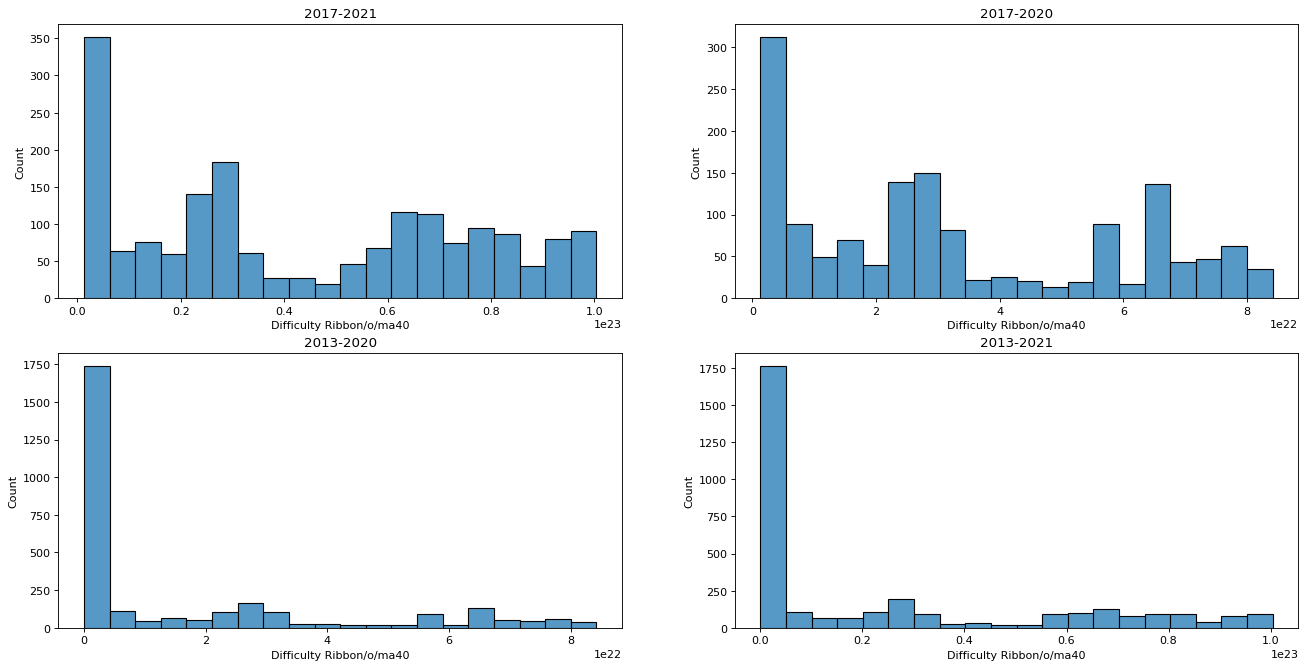

In [18]:
difficulty_ribbon["Difficulty Ribbon/o/ma40"][difficulty_ribbon["Timestamp"].dt.year == 2014].mean()
difficultyh = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2016) & (difficulty_ribbon["Timestamp"].dt.year < 2022),:]
difficultyn = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2016) & (difficulty_ribbon["Timestamp"].dt.year < 2021),:]
difficultynh = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2012) & (difficulty_ribbon["Timestamp"].dt.year < 2021),:]
difficultyf = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2012) & (difficulty_ribbon["Timestamp"].dt.year < 2022),:]

fig, axes = plt.subplots(2, 2, figsize=(20,10), dpi= 80)
sns.histplot(difficultyh["Difficulty Ribbon/o/ma40"], ax=axes[0,0],bins = 20)
sns.histplot(difficultyn["Difficulty Ribbon/o/ma40"], ax=axes[0,1],bins = 20)
sns.histplot(difficultynh["Difficulty Ribbon/o/ma40"], ax=axes[1,0],bins = 20)
sns.histplot(difficultyf["Difficulty Ribbon/o/ma40"], ax=axes[1,1],bins = 20)
axes[0,0].title.set_text('2017-2021')
axes[0,1].title.set_text('2017-2020')
axes[1,0].title.set_text('2013-2020')
axes[1,1].title.set_text('2013-2021')

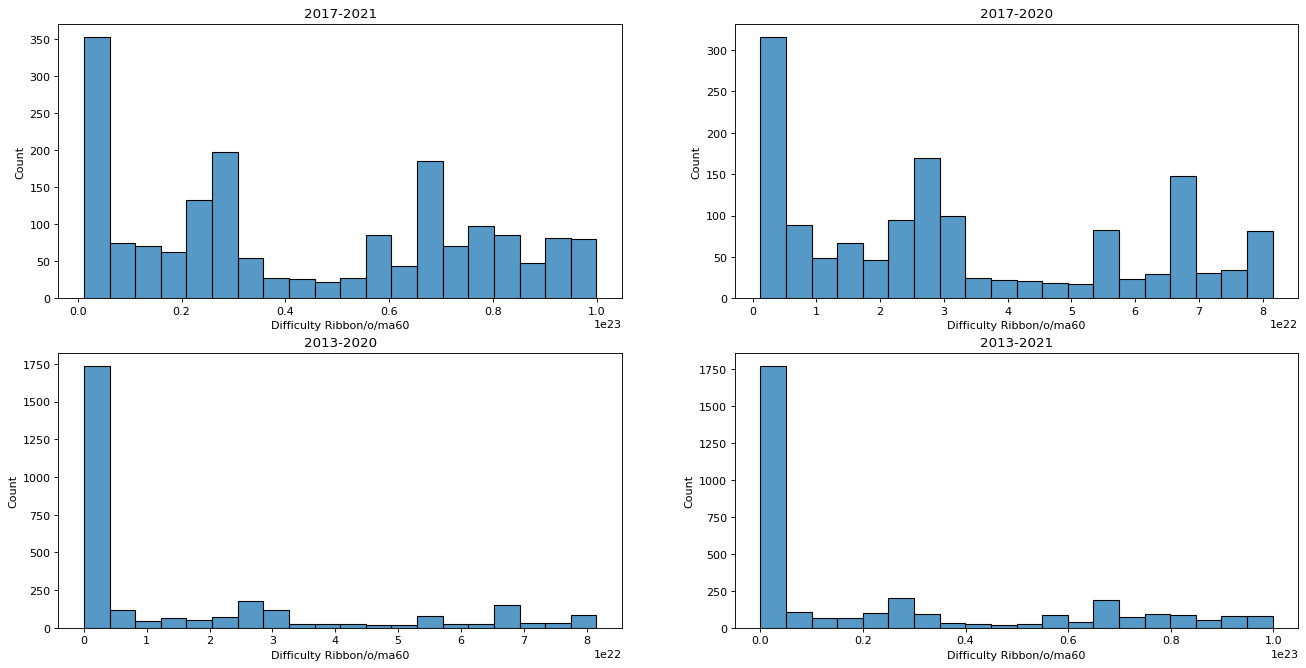

In [19]:
difficulty_ribbon["Difficulty Ribbon/o/ma60"][difficulty_ribbon["Timestamp"].dt.year == 2014].mean()
difficultyh = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2016) & (difficulty_ribbon["Timestamp"].dt.year < 2022),:]
difficultyn = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2016) & (difficulty_ribbon["Timestamp"].dt.year < 2021),:]
difficultynh = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2012) & (difficulty_ribbon["Timestamp"].dt.year < 2021),:]
difficultyf = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2012) & (difficulty_ribbon["Timestamp"].dt.year < 2022),:]

fig, axes = plt.subplots(2, 2, figsize=(20,10), dpi= 80)
sns.histplot(difficultyh["Difficulty Ribbon/o/ma60"], ax=axes[0,0],bins = 20)
sns.histplot(difficultyn["Difficulty Ribbon/o/ma60"], ax=axes[0,1],bins = 20)
sns.histplot(difficultynh["Difficulty Ribbon/o/ma60"], ax=axes[1,0],bins = 20)
sns.histplot(difficultyf["Difficulty Ribbon/o/ma60"], ax=axes[1,1],bins = 20)
axes[0,0].title.set_text('2017-2021')
axes[0,1].title.set_text('2017-2020')
axes[1,0].title.set_text('2013-2020')
axes[1,1].title.set_text('2013-2021')

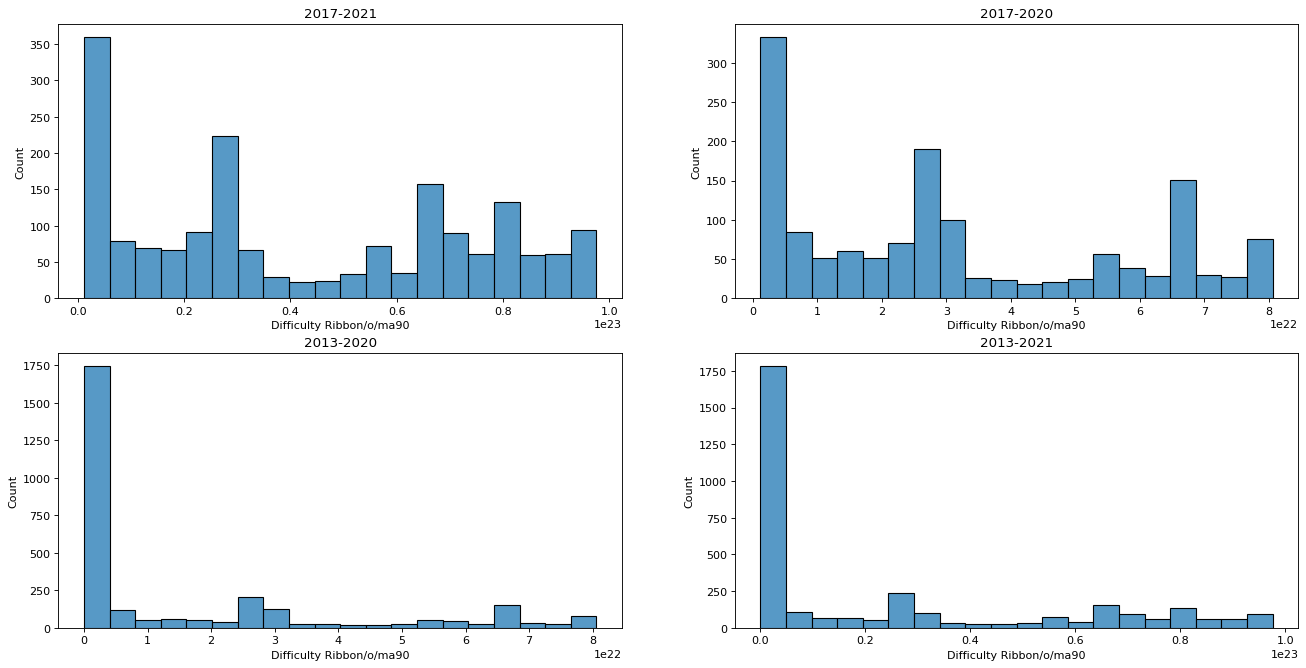

In [20]:
difficulty_ribbon["Difficulty Ribbon/o/ma90"][difficulty_ribbon["Timestamp"].dt.year == 2014].mean()
difficultyh = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2016) & (difficulty_ribbon["Timestamp"].dt.year < 2022),:]
difficultyn = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2016) & (difficulty_ribbon["Timestamp"].dt.year < 2021),:]
difficultynh = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2012) & (difficulty_ribbon["Timestamp"].dt.year < 2021),:]
difficultyf = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2012) & (difficulty_ribbon["Timestamp"].dt.year < 2022),:]

fig, axes = plt.subplots(2, 2, figsize=(20,10), dpi= 80)
sns.histplot(difficultyh["Difficulty Ribbon/o/ma90"], ax=axes[0,0],bins = 20)
sns.histplot(difficultyn["Difficulty Ribbon/o/ma90"], ax=axes[0,1],bins = 20)
sns.histplot(difficultynh["Difficulty Ribbon/o/ma90"], ax=axes[1,0],bins = 20)
sns.histplot(difficultyf["Difficulty Ribbon/o/ma90"], ax=axes[1,1],bins = 20)
axes[0,0].title.set_text('2017-2021')
axes[0,1].title.set_text('2017-2020')
axes[1,0].title.set_text('2013-2020')
axes[1,1].title.set_text('2013-2021')

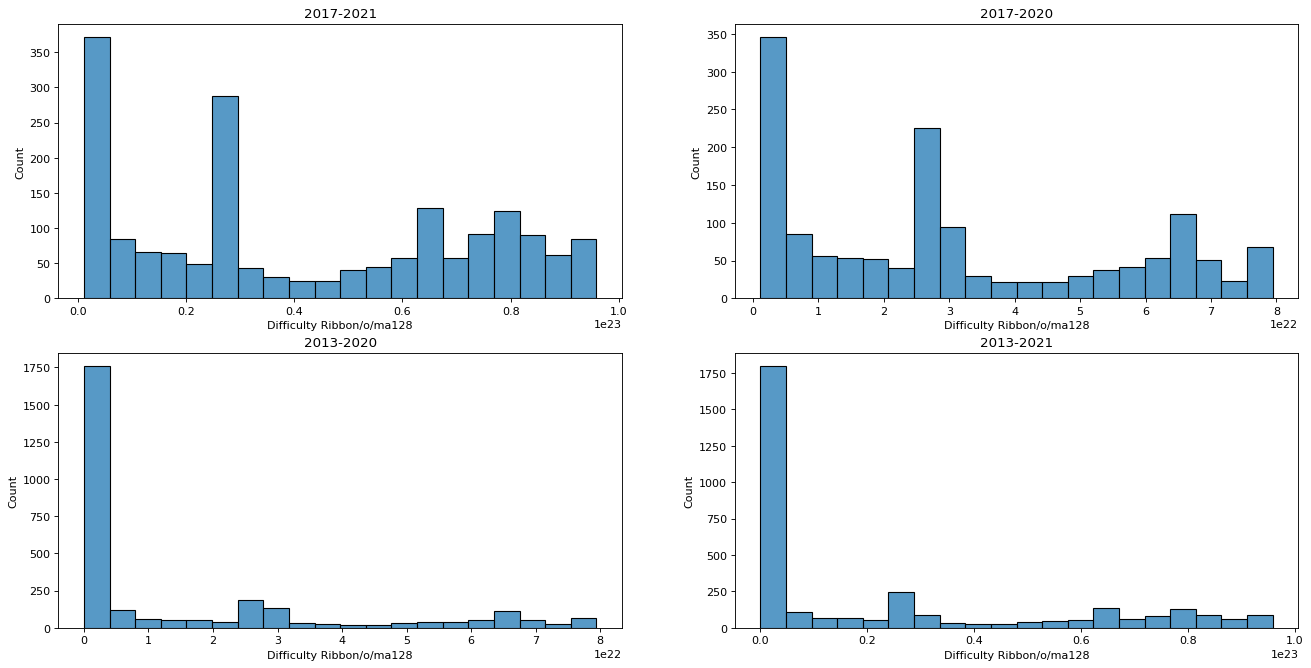

In [21]:
difficulty_ribbon["Difficulty Ribbon/o/ma128"][difficulty_ribbon["Timestamp"].dt.year == 2014].mean()
difficultyh = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2016) & (difficulty_ribbon["Timestamp"].dt.year < 2022),:]
difficultyn = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2016) & (difficulty_ribbon["Timestamp"].dt.year < 2021),:]
difficultynh = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2012) & (difficulty_ribbon["Timestamp"].dt.year < 2021),:]
difficultyf = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2012) & (difficulty_ribbon["Timestamp"].dt.year < 2022),:]

fig, axes = plt.subplots(2, 2, figsize=(20,10), dpi= 80)
sns.histplot(difficultyh["Difficulty Ribbon/o/ma128"], ax=axes[0,0],bins = 20)
sns.histplot(difficultyn["Difficulty Ribbon/o/ma128"], ax=axes[0,1],bins = 20)
sns.histplot(difficultynh["Difficulty Ribbon/o/ma128"], ax=axes[1,0],bins = 20)
sns.histplot(difficultyf["Difficulty Ribbon/o/ma128"], ax=axes[1,1],bins = 20)
axes[0,0].title.set_text('2017-2021')
axes[0,1].title.set_text('2017-2020')
axes[1,0].title.set_text('2013-2020')
axes[1,1].title.set_text('2013-2021')

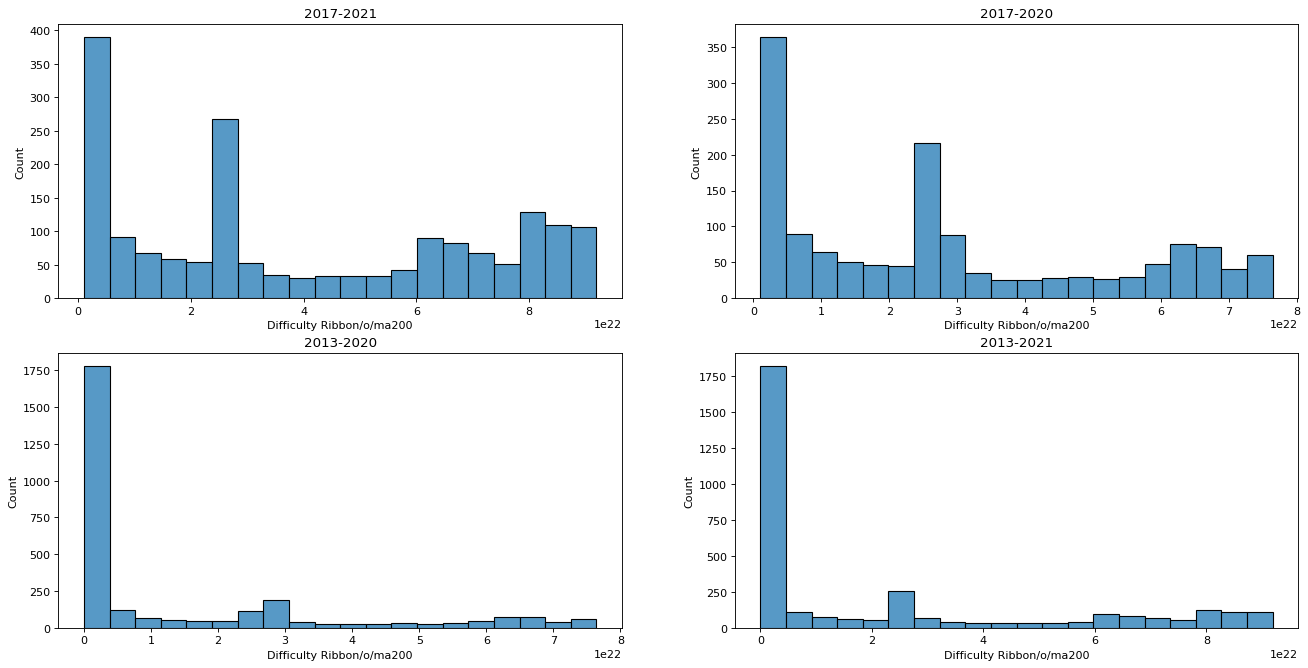

In [22]:
difficulty_ribbon["Difficulty Ribbon/o/ma200"][difficulty_ribbon["Timestamp"].dt.year == 2014].mean()
difficultyh = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2016) & (difficulty_ribbon["Timestamp"].dt.year < 2022),:]
difficultyn = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2016) & (difficulty_ribbon["Timestamp"].dt.year < 2021),:]
difficultynh = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2012) & (difficulty_ribbon["Timestamp"].dt.year < 2021),:]
difficultyf = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2012) & (difficulty_ribbon["Timestamp"].dt.year < 2022),:]

fig, axes = plt.subplots(2, 2, figsize=(20,10), dpi= 80)
sns.histplot(difficultyh["Difficulty Ribbon/o/ma200"], ax=axes[0,0],bins = 20)
sns.histplot(difficultyn["Difficulty Ribbon/o/ma200"], ax=axes[0,1],bins = 20)
sns.histplot(difficultynh["Difficulty Ribbon/o/ma200"], ax=axes[1,0],bins = 20)
sns.histplot(difficultyf["Difficulty Ribbon/o/ma200"], ax=axes[1,1],bins = 20)
axes[0,0].title.set_text('2017-2021')
axes[0,1].title.set_text('2017-2020')
axes[1,0].title.set_text('2013-2020')
axes[1,1].title.set_text('2013-2021')

Text(0.5, 0.98, 'DIFFICULTY RIBBON / 2010-2021 ')

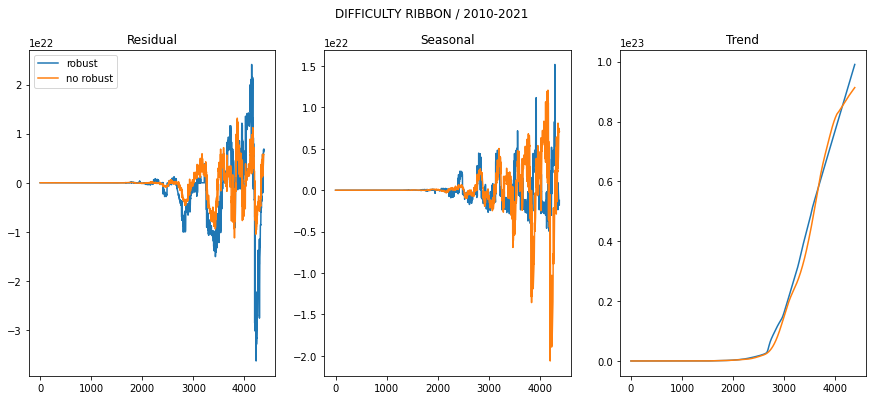

In [24]:
plt.rc("figure", figsize=(16, 16))
res1 = STL(difficulty_ribbon["Difficulty Ribbon/o/ma9"], period=365, robust=True).fit()
res2 = STL(difficulty_ribbon["Difficulty Ribbon/o/ma9"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res1.resid, label="robust")
axs[0].plot(res2.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res1.seasonal)
axs[1].plot(res2.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res1.trend)
axs[2].plot(res2.trend)
axs[2].title.set_text('Trend')


fig.suptitle('DIFFICULTY RIBBON / 2010-2021 ')

Text(0.5, 0.98, 'DIFFICULTY RIBBON / 2010-2021 ')

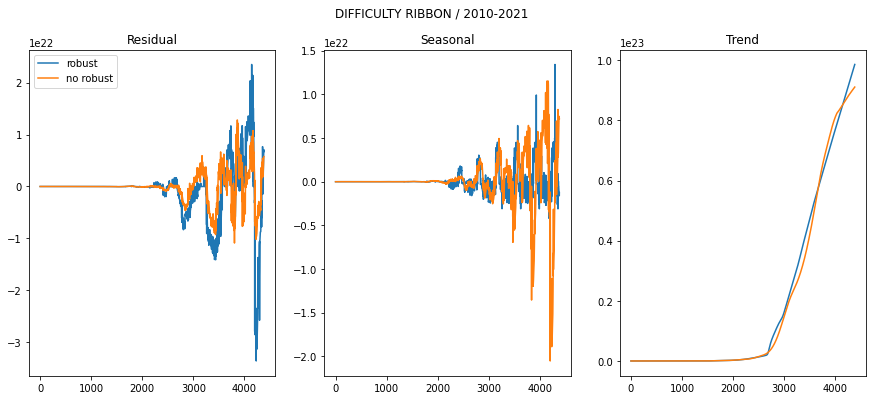

In [25]:
plt.rc("figure", figsize=(16, 16))
res1 = STL(difficulty_ribbon["Difficulty Ribbon/o/ma14"], period=365, robust=True).fit()
res2 = STL(difficulty_ribbon["Difficulty Ribbon/o/ma14"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res1.resid, label="robust")
axs[0].plot(res2.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res1.seasonal)
axs[1].plot(res2.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res1.trend)
axs[2].plot(res2.trend)
axs[2].title.set_text('Trend')


fig.suptitle('DIFFICULTY RIBBON / 2010-2021 ')

Text(0.5, 0.98, 'DIFFICULTY RIBBON / 2010-2021 ')

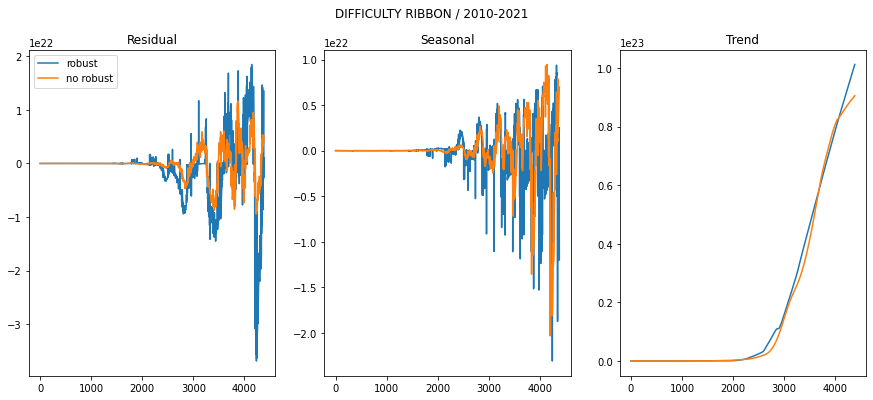

In [26]:
plt.rc("figure", figsize=(16, 16))
res1 = STL(difficulty_ribbon["Difficulty Ribbon/o/ma25"], period=365, robust=True).fit()
res2 = STL(difficulty_ribbon["Difficulty Ribbon/o/ma25"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res1.resid, label="robust")
axs[0].plot(res2.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res1.seasonal)
axs[1].plot(res2.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res1.trend)
axs[2].plot(res2.trend)
axs[2].title.set_text('Trend')


fig.suptitle('DIFFICULTY RIBBON / 2010-2021 ')

Text(0.5, 0.98, 'DIFFICULTY RIBBON / 2010-2021 ')

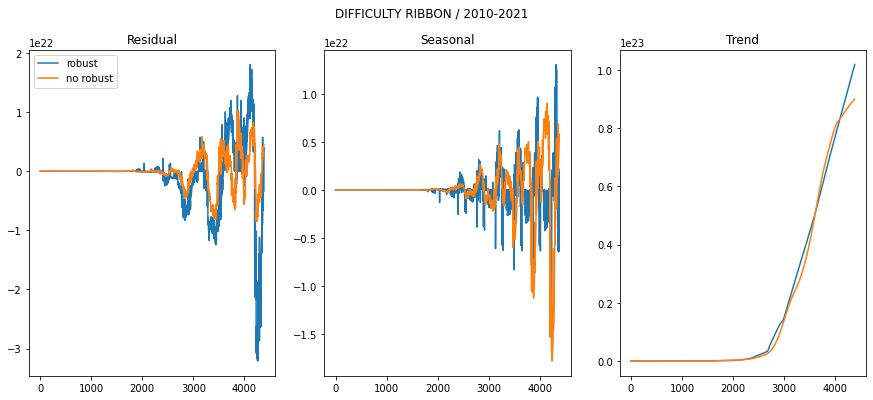

In [27]:
plt.rc("figure", figsize=(16, 16))
res1 = STL(difficulty_ribbon["Difficulty Ribbon/o/ma40"], period=365, robust=True).fit()
res2 = STL(difficulty_ribbon["Difficulty Ribbon/o/ma40"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res1.resid, label="robust")
axs[0].plot(res2.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res1.seasonal)
axs[1].plot(res2.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res1.trend)
axs[2].plot(res2.trend)
axs[2].title.set_text('Trend')


fig.suptitle('DIFFICULTY RIBBON / 2010-2021 ')

Text(0.5, 0.98, 'DIFFICULTY RIBBON / 2010-2021 ')

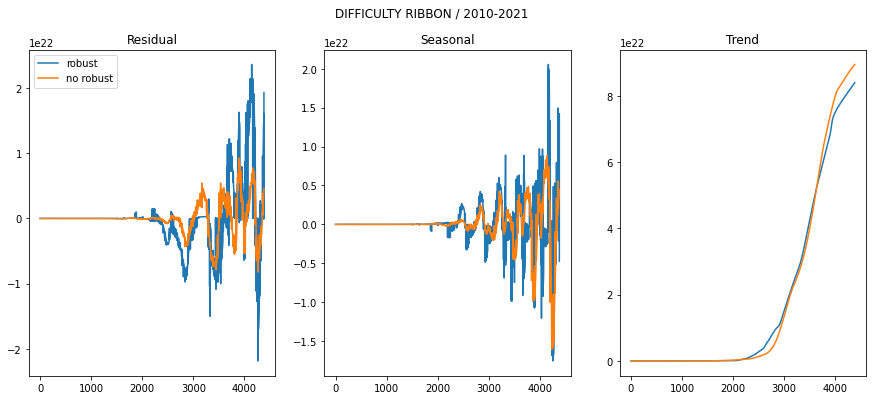

In [28]:
plt.rc("figure", figsize=(16, 16))
res1 = STL(difficulty_ribbon["Difficulty Ribbon/o/ma60"], period=365, robust=True).fit()
res2 = STL(difficulty_ribbon["Difficulty Ribbon/o/ma60"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res1.resid, label="robust")
axs[0].plot(res2.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res1.seasonal)
axs[1].plot(res2.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res1.trend)
axs[2].plot(res2.trend)
axs[2].title.set_text('Trend')


fig.suptitle('DIFFICULTY RIBBON / 2010-2021 ')

Text(0.5, 0.98, 'DIFFICULTY RIBBON / 2010-2021 ')

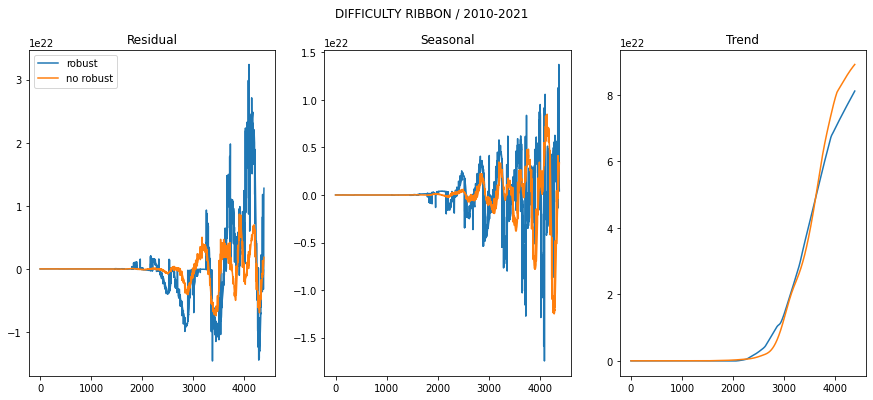

In [29]:
plt.rc("figure", figsize=(16, 16))
res1 = STL(difficulty_ribbon["Difficulty Ribbon/o/ma90"], period=365, robust=True).fit()
res2 = STL(difficulty_ribbon["Difficulty Ribbon/o/ma90"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res1.resid, label="robust")
axs[0].plot(res2.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res1.seasonal)
axs[1].plot(res2.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res1.trend)
axs[2].plot(res2.trend)
axs[2].title.set_text('Trend')


fig.suptitle('DIFFICULTY RIBBON / 2010-2021 ')

Text(0.5, 0.98, 'DIFFICULTY RIBBON / 2010-2021 ')

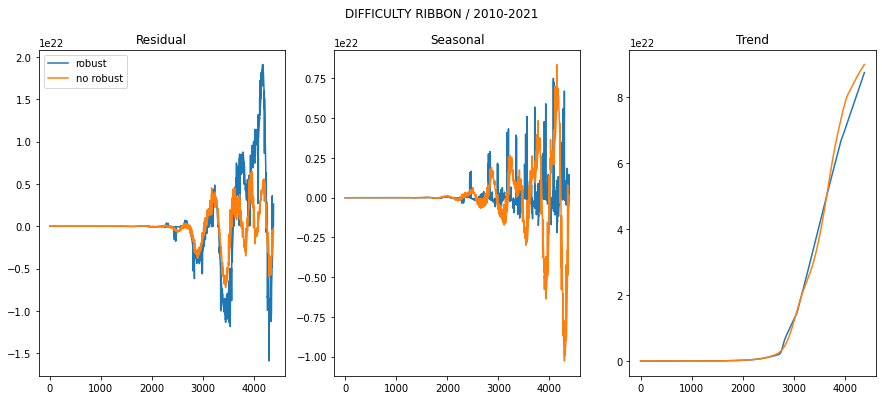

In [30]:
plt.rc("figure", figsize=(16, 16))
res1 = STL(difficulty_ribbon["Difficulty Ribbon/o/ma128"], period=365, robust=True).fit()
res2 = STL(difficulty_ribbon["Difficulty Ribbon/o/ma128"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res1.resid, label="robust")
axs[0].plot(res2.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res1.seasonal)
axs[1].plot(res2.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res1.trend)
axs[2].plot(res2.trend)
axs[2].title.set_text('Trend')


fig.suptitle('DIFFICULTY RIBBON / 2010-2021 ')

Text(0.5, 0.98, 'DIFFICULTY RIBBON / 2010-2021 ')

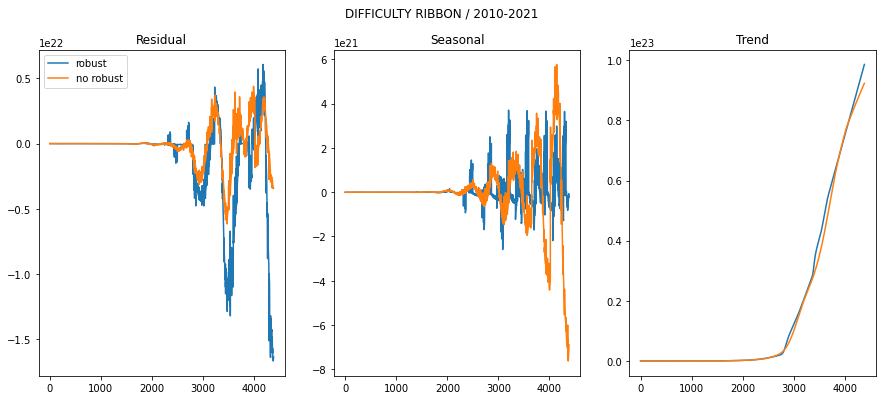

In [31]:
plt.rc("figure", figsize=(16, 16))
res1 = STL(difficulty_ribbon["Difficulty Ribbon/o/ma200"], period=365, robust=True).fit()
res2 = STL(difficulty_ribbon["Difficulty Ribbon/o/ma200"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res1.resid, label="robust")
axs[0].plot(res2.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res1.seasonal)
axs[1].plot(res2.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res1.trend)
axs[2].plot(res2.trend)
axs[2].title.set_text('Trend')


fig.suptitle('DIFFICULTY RIBBON / 2010-2021 ')

Text(0.5, 0.98, 'DIFFICULTY RIBBON/ 2017-2021 ')

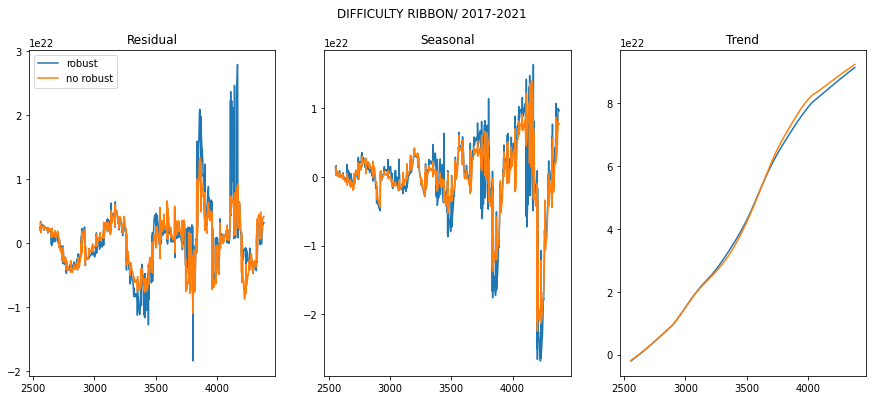

In [34]:
difficulty_ribbon["Difficulty Ribbon/o/ma9"][difficulty_ribbon["Timestamp"].dt.year == 2014].mean()
difficultyh = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2016) & (difficulty_ribbon["Timestamp"].dt.year < 2022),:]

plt.rc("figure", figsize=(16, 16))
res3 = STL(difficultyh["Difficulty Ribbon/o/ma9"], period=365, robust=True).fit()
res4 = STL(difficultyh["Difficulty Ribbon/o/ma9"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res3.resid, label="robust")
axs[0].plot(res4.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res3.seasonal)
axs[1].plot(res4.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res3.trend)
axs[2].plot(res4.trend)
axs[2].title.set_text('Trend')


fig.suptitle('DIFFICULTY RIBBON/ 2017-2021 ')

Text(0.5, 0.98, 'DIFFICULTY RIBBON/ 2017-2021 ')

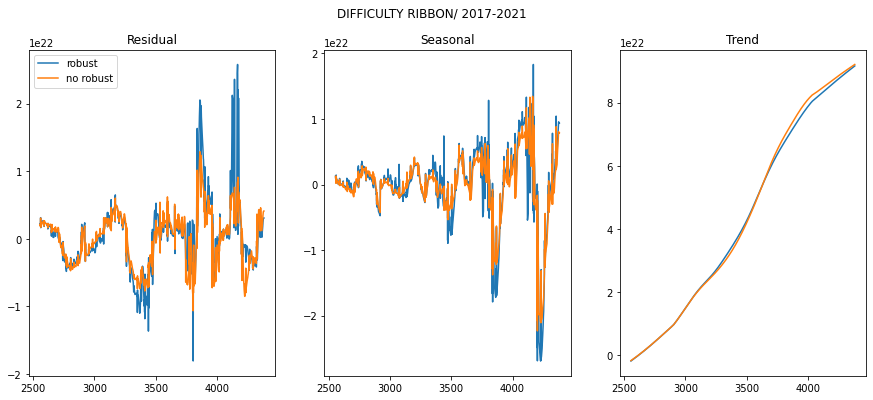

In [35]:
difficulty_ribbon["Difficulty Ribbon/o/ma14"][difficulty_ribbon["Timestamp"].dt.year == 2014].mean()
difficultyh = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2016) & (difficulty_ribbon["Timestamp"].dt.year < 2022),:]

plt.rc("figure", figsize=(16, 16))
res3 = STL(difficultyh["Difficulty Ribbon/o/ma14"], period=365, robust=True).fit()
res4 = STL(difficultyh["Difficulty Ribbon/o/ma14"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res3.resid, label="robust")
axs[0].plot(res4.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res3.seasonal)
axs[1].plot(res4.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res3.trend)
axs[2].plot(res4.trend)
axs[2].title.set_text('Trend')


fig.suptitle('DIFFICULTY RIBBON/ 2017-2021 ')

Text(0.5, 0.98, 'DIFFICULTY RIBBON/ 2017-2021 ')

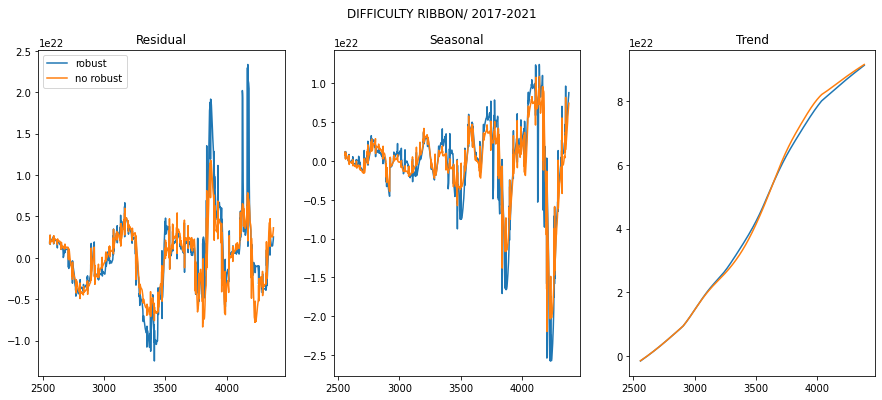

In [36]:
difficulty_ribbon["Difficulty Ribbon/o/ma25"][difficulty_ribbon["Timestamp"].dt.year == 2014].mean()
difficultyh = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2016) & (difficulty_ribbon["Timestamp"].dt.year < 2022),:]

plt.rc("figure", figsize=(16, 16))
res3 = STL(difficultyh["Difficulty Ribbon/o/ma25"], period=365, robust=True).fit()
res4 = STL(difficultyh["Difficulty Ribbon/o/ma25"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res3.resid, label="robust")
axs[0].plot(res4.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res3.seasonal)
axs[1].plot(res4.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res3.trend)
axs[2].plot(res4.trend)
axs[2].title.set_text('Trend')


fig.suptitle('DIFFICULTY RIBBON/ 2017-2021 ')

Text(0.5, 0.98, 'DIFFICULTY RIBBON/ 2017-2021 ')

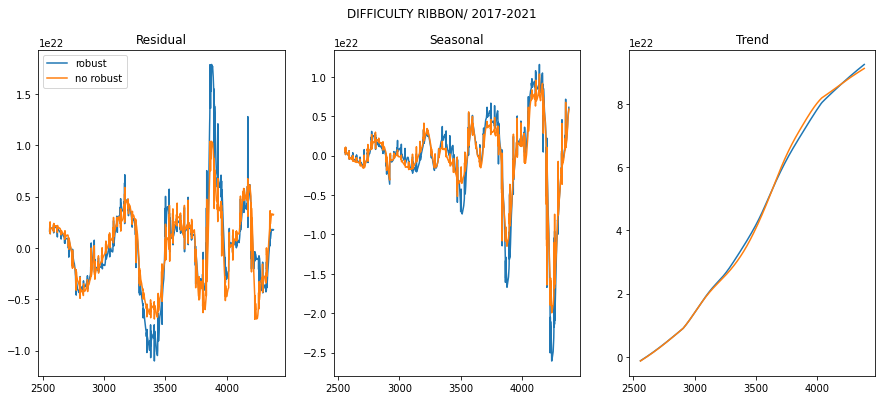

In [37]:
difficulty_ribbon["Difficulty Ribbon/o/ma40"][difficulty_ribbon["Timestamp"].dt.year == 2014].mean()
difficultyh = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2016) & (difficulty_ribbon["Timestamp"].dt.year < 2022),:]

plt.rc("figure", figsize=(16, 16))
res3 = STL(difficultyh["Difficulty Ribbon/o/ma40"], period=365, robust=True).fit()
res4 = STL(difficultyh["Difficulty Ribbon/o/ma40"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res3.resid, label="robust")
axs[0].plot(res4.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res3.seasonal)
axs[1].plot(res4.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res3.trend)
axs[2].plot(res4.trend)
axs[2].title.set_text('Trend')


fig.suptitle('DIFFICULTY RIBBON/ 2017-2021 ')

Text(0.5, 0.98, 'DIFFICULTY RIBBON/ 2017-2021 ')

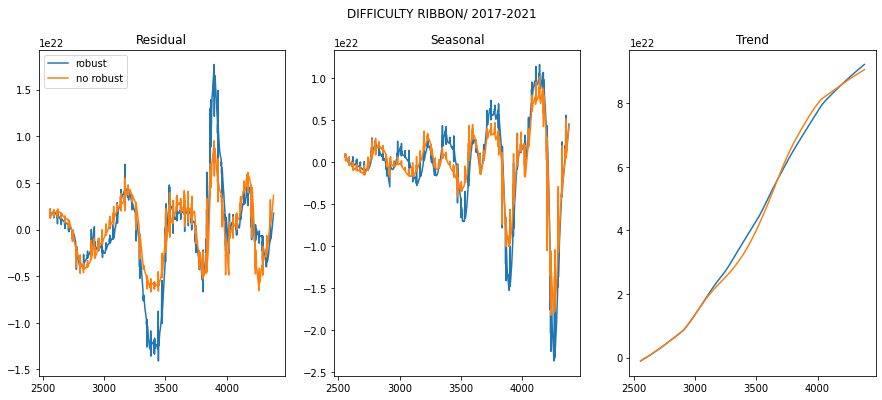

In [38]:
difficulty_ribbon["Difficulty Ribbon/o/ma60"][difficulty_ribbon["Timestamp"].dt.year == 2014].mean()
difficultyh = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2016) & (difficulty_ribbon["Timestamp"].dt.year < 2022),:]

plt.rc("figure", figsize=(16, 16))
res3 = STL(difficultyh["Difficulty Ribbon/o/ma60"], period=365, robust=True).fit()
res4 = STL(difficultyh["Difficulty Ribbon/o/ma60"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res3.resid, label="robust")
axs[0].plot(res4.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res3.seasonal)
axs[1].plot(res4.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res3.trend)
axs[2].plot(res4.trend)
axs[2].title.set_text('Trend')


fig.suptitle('DIFFICULTY RIBBON/ 2017-2021 ')

Text(0.5, 0.98, 'DIFFICULTY RIBBON/ 2017-2021 ')

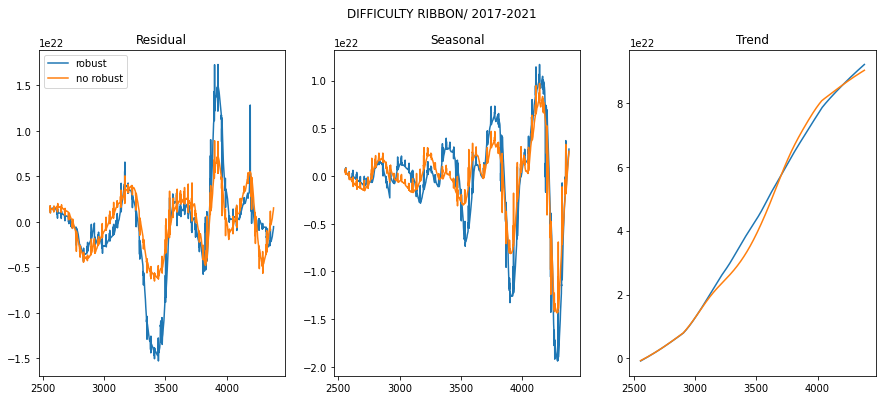

In [39]:
difficulty_ribbon["Difficulty Ribbon/o/ma90"][difficulty_ribbon["Timestamp"].dt.year == 2014].mean()
difficultyh = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2016) & (difficulty_ribbon["Timestamp"].dt.year < 2022),:]

plt.rc("figure", figsize=(16, 16))
res3 = STL(difficultyh["Difficulty Ribbon/o/ma90"], period=365, robust=True).fit()
res4 = STL(difficultyh["Difficulty Ribbon/o/ma90"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res3.resid, label="robust")
axs[0].plot(res4.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res3.seasonal)
axs[1].plot(res4.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res3.trend)
axs[2].plot(res4.trend)
axs[2].title.set_text('Trend')


fig.suptitle('DIFFICULTY RIBBON/ 2017-2021 ')

Text(0.5, 0.98, 'DIFFICULTY RIBBON/ 2017-2021 ')

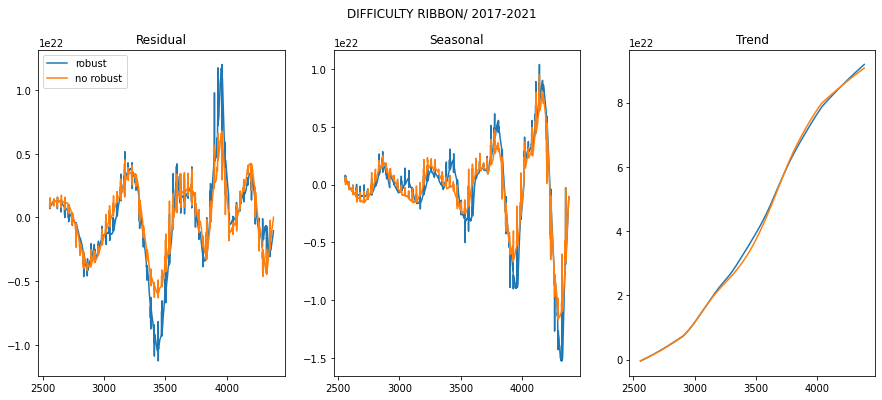

In [40]:
difficulty_ribbon["Difficulty Ribbon/o/ma128"][difficulty_ribbon["Timestamp"].dt.year == 2014].mean()
difficultyh = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2016) & (difficulty_ribbon["Timestamp"].dt.year < 2022),:]

plt.rc("figure", figsize=(16, 16))
res3 = STL(difficultyh["Difficulty Ribbon/o/ma128"], period=365, robust=True).fit()
res4 = STL(difficultyh["Difficulty Ribbon/o/ma128"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res3.resid, label="robust")
axs[0].plot(res4.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res3.seasonal)
axs[1].plot(res4.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res3.trend)
axs[2].plot(res4.trend)
axs[2].title.set_text('Trend')


fig.suptitle('DIFFICULTY RIBBON/ 2017-2021 ')

Text(0.5, 0.98, 'DIFFICULTY RIBBON/ 2017-2021 ')

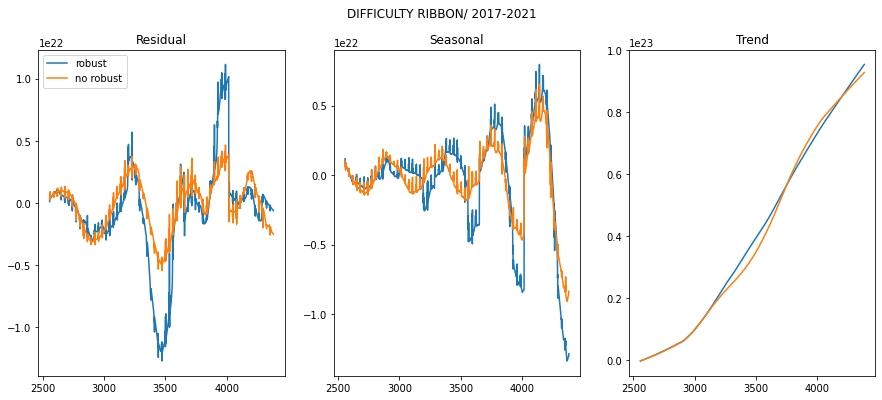

In [41]:
difficulty_ribbon["Difficulty Ribbon/o/ma200"][difficulty_ribbon["Timestamp"].dt.year == 2014].mean()
difficultyh = difficulty_ribbon.loc[(difficulty_ribbon["Timestamp"].dt.year > 2016) & (difficulty_ribbon["Timestamp"].dt.year < 2022),:]

plt.rc("figure", figsize=(16, 16))
res3 = STL(difficultyh["Difficulty Ribbon/o/ma200"], period=365, robust=True).fit()
res4 = STL(difficultyh["Difficulty Ribbon/o/ma200"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res3.resid, label="robust")
axs[0].plot(res4.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res3.seasonal)
axs[1].plot(res4.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res3.trend)
axs[2].plot(res4.trend)
axs[2].title.set_text('Trend')


fig.suptitle('DIFFICULTY RIBBON/ 2017-2021 ')

#### Trend interpolation
We now try to interploate the trend with an exponential function.

In [42]:
#CI SONO DEI NULL VALUES DENTRO IL TREND. HO TROVATO QUESTA TECNICA

np.log(res3.trend)

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


2557          NaN
2558          NaN
2559          NaN
2560          NaN
2561          NaN
          ...    
4378    52.910691
4379    52.911279
4380    52.911867
4381    52.912454
4382    52.913041
Name: trend, Length: 1826, dtype: float64

In [44]:
# y = a*exp(bx) --> log(y) = log(a)+bx
idx = np.isfinite(np.arange(len(difficultyh))) & np.isfinite(np.log(res3.trend))
coefs = np.polyfit(np.arange(len(difficultyh))[idx]+1, np.log(res3.trend)[idx],1)
coefs
# y = exp(coefs[1])*exp(coefs[0]*x)

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


array([2.40571839e-03, 4.92930929e+01])

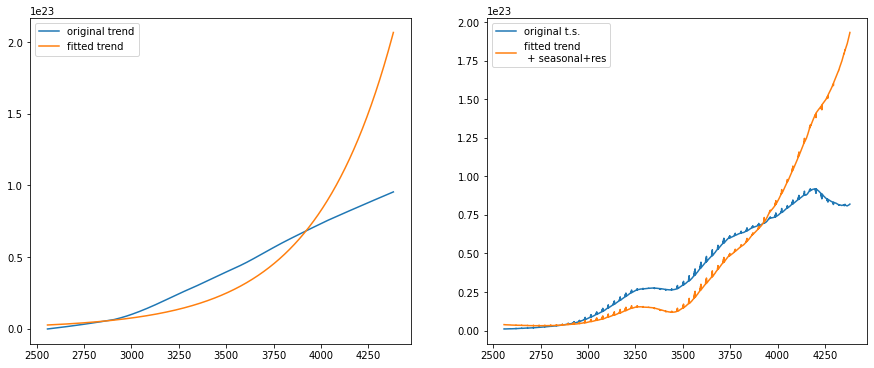

In [47]:
fitted = pd.Series(np.exp(coefs[1])*np.exp(coefs[0]*(np.arange(len(difficultyh))+1)), index = difficultyh.index)
#fitted.plot()
#res3.trend.plot()


fitted_season = fitted+res3.seasonal # fitted trend + seasonal decomposed series (orange) non so se ha senso calcolarlo
fitted_compl = fitted_season+res3.resid # fitted trend + seasonal decomposed series + residual decomposed series (green)
#hashh["Value"].plot()
#fitted_season.plot()
#fitted_compl.plot()


fig, axs = plt.subplots(ncols=2, figsize=(15,6))
axs[0].plot(res3.trend, label="original trend")
axs[0].plot(fitted, label="fitted trend")
axs[0].legend()
axs[1].plot(difficultyh["Difficulty Ribbon/o/ma200"], label='original t.s.')
#axs[1].plot(fitted_season, label='fitted trend\n + seasonal')
axs[1].plot(fitted_compl, label='fitted trend\n + seasonal+res')
axs[1].legend()

USO DIFFICULTYH PERCHE' SONO TROPPE SERIE, QUINDI SE USO I DATI COMPLETI CI VUOLE TROPPO TEMPO, E IN OGNI CASO COSI' SEMPLIFICO ANCHE LA ANALISIS


In [53]:
difficultyh

Timestamp  Difficulty Ribbon/o/ma128  Difficulty Ribbon/o/ma14  \
2557 2017-01-01               1.149881e+21              1.370355e+21   
2558 2017-01-01               1.119737e+21              1.343658e+21   
2559 2017-01-02               1.123103e+21              1.345970e+21   
2560 2017-01-02               1.188341e+21              1.429293e+21   
2561 2017-01-03               1.242540e+21              1.601768e+21   
...         ...                        ...                       ...   
4378 2021-12-26               8.835174e+22              1.039652e+23   
4379 2021-12-27               8.864421e+22              1.039889e+23   
4380 2021-12-28               8.893667e+22              1.040125e+23   
4381 2021-12-29               8.922914e+22              1.040361e+23   
4382 2021-12-31               8.974499e+22              1.040834e+23   

      Difficulty Ribbon/o/ma200  Difficulty Ribbon/o/ma25  \
2557               1.064236e+21              1.353523e+21   
2558               1.041466e+21              1.310446e+21   
2559               1.044078e+21              1.315759e+21   
2560               1.091520e+21              1.399473e+21   
2561               1.128877e+21              1.520457e+21   
...                         ...                       ...   
4378               8.161055e+22              1.010691e+23   
4379               8.167979e+22              1.014018e+23   
4380               8.174904e+22              1.017345e+23   
4381               8.181829e+22              1.020673e+23   
4382               8.200467e+22              1.027327e+23   

      Difficulty Ribbon/o/ma40  Difficulty Ribbon/o/ma60  \
2557              1.312843e+21              1.266997e+21   
2558              1.276100e+21              1.224847e+21   
2559              1.279953e+21              1.229433e+21   
2560              1.366674e+21              1.318112e+21   
2561              1.457104e+21              1.393672e+21   
...                        ...                       ...   
4378              9.954208e+22              9.724941e+22   
4379              9.971369e+22              9.754933e+22   
4380              9.988529e+22              9.784925e+22   
4381              1.000569e+23              9.814918e+22   
4382              1.004001e+23              9.852327e+22   

      Difficulty Ribbon/o/ma9  Difficulty Ribbon/o/ma90  year  
2557             1.373629e+21              1.210200e+21  2017  
2558             1.350079e+21              1.180570e+21  2017  
2559             1.353674e+21              1.184219e+21  2017  
2560             1.446974e+21              1.247837e+21  2017  
2561             1.687764e+21              1.311659e+21  2017  
...                       ...                       ...   ...  
4378             1.039915e+23              9.314694e+22  2021  
4379             1.040283e+23              9.339866e+22  2021  
4380             1.040650e+23              9.365038e+22  2021  
4381             1.041018e+23              9.390210e+22  2021  
4382             1.041753e+23              9.440553e+22  2021  

[1826 rows x 10 columns]

#### Adesso vado a usare solamente alcune colonne del difficulty ribbon, ovvero quelle  ma9 e ma200, che sono quelle più usate negil investimenti

# TRAIN/VAL/TEST SPLIT

In [145]:
series9 = difficultyh["Difficulty Ribbon/o/ma9"]
#series14 = difficultyh["Difficulty Ribbon/o/ma14"]
#series25 = difficultyh["Difficulty Ribbon/o/ma25"]
#series40 = difficultyh["Difficulty Ribbon/o/ma40"]
#series60 = difficultyh["Difficulty Ribbon/o/ma60"]
#series90 = difficultyh["Difficulty Ribbon/o/ma90"]
#series128 = difficultyh["Difficulty Ribbon/o/ma128"]
series200 = difficultyh["Difficulty Ribbon/o/ma200"]

#9
# Create train data set
train_split_date9 = '2020-12-31'
train_split_index9 = np.where(difficultyh.Timestamp == train_split_date9)[0][0]
x_train9 = difficultyh.loc[difficultyh['Timestamp'] <= train_split_date9]["Difficulty Ribbon/o/ma9"]

# Create test data set
test_split_date9 = '2021-06-29'
test_split_index9 = np.where(difficultyh.Timestamp == test_split_date9)[0][0]
x_test9 = difficultyh.loc[difficultyh['Timestamp'] >= test_split_date9]["Difficulty Ribbon/o/ma9"]

# Create valid data set
valid_split_index9 = (train_split_index9.max(),test_split_index9.min())
x_valid9 = difficultyh.loc[(difficultyh['Timestamp'] < test_split_date9) & (difficultyh['Timestamp'] > train_split_date9)]["Difficulty Ribbon/o/ma9"]




#200
# Create train data set
train_split_date200 = '2020-12-31'
train_split_index200 = np.where(difficultyh.Timestamp == train_split_date200)[0][0]
x_train200 = difficultyh.loc[difficultyh['Timestamp'] <= train_split_date200]["Difficulty Ribbon/o/ma200"]

# Create test data set
test_split_date200 = '2021-06-29'
test_split_index200 = np.where(difficultyh.Timestamp == test_split_date200)[0][0]
x_test200 = difficultyh.loc[difficultyh['Timestamp'] >= test_split_date200]["Difficulty Ribbon/o/ma200"]

# Create valid data set
valid_split_index200 = (train_split_index200.max(),test_split_index200.min())
x_valid200 = difficultyh.loc[(difficultyh['Timestamp'] < test_split_date200) & (difficultyh['Timestamp'] > train_split_date200)]["Difficulty Ribbon/o/ma200"]

Train set ranging from 2017-01-01 to 2020-12-31 00:00:00 - Number of days = 1461
Validation set ranging from 2021-01-01 00:00:00 to 2021-06-28 00:00:00 - Number of days = 180
Test set ranging from 2021-06-29 00:00:00 to 2021-12-31 00:00:00 - Number of days = 185


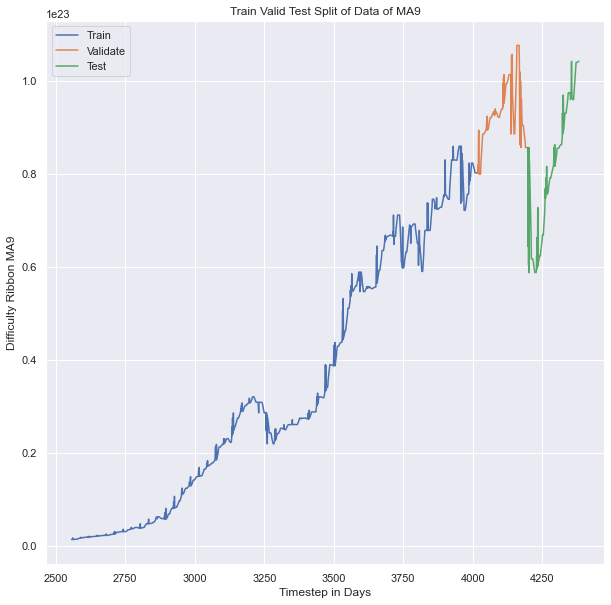

In [146]:
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train9, label = 'Train')
plt.plot(x_valid9, label = 'Validate')
plt.plot(x_test9, label = 'Test')
plt.title('Train Valid Test Split of Data of MA9')
plt.ylabel('Difficulty Ribbon MA9')
plt.xlabel('Timestep in Days')
plt.legend()
#print(x_train9.index.max(),x_valid9.index.min(),x_valid9.index.max(),x_test9.index.min(),x_test9.index.max())
print("Train set ranging from 2017-01-01 to", difficultyh.loc[4017]["Timestamp"], "- Number of days =", len(x_train9.index))
print("Validation set ranging from", difficultyh.loc[x_valid9.index.min()]["Timestamp"], "to", difficultyh.loc[x_valid9.index.max()]["Timestamp"], "- Number of days =", len(x_valid9.index))
print("Test set ranging from", difficultyh.loc[x_test9.index.min()]["Timestamp"], "to", difficultyh.loc[x_test9.index.max()]["Timestamp"], "- Number of days =", len(x_test9.index))

Train set ranging from 2017-01-01 to 2020-12-31 00:00:00 - Number of days = 1461
Validation set ranging from 2021-01-01 00:00:00 to 2021-06-28 00:00:00 - Number of days = 180
Test set ranging from 2021-06-29 00:00:00 to 2021-12-31 00:00:00 - Number of days = 185


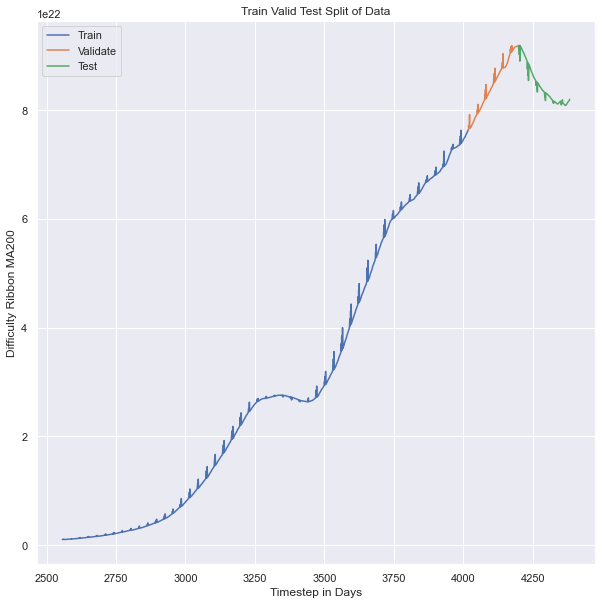

In [147]:
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train200, label = 'Train')
plt.plot(x_valid200, label = 'Validate')
plt.plot(x_test200, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Difficulty Ribbon MA200')
plt.xlabel('Timestep in Days')
plt.legend()
#print(x_train200.index.max(),x_valid200.index.min(),x_valid200.index.max(),x_test200.index.min(),x_test200.index.max())
print("Train set ranging from 2017-01-01 to", difficultyh.loc[4017]["Timestamp"], "- Number of days =", len(x_train200.index))
print("Validation set ranging from", difficultyh.loc[x_valid200.index.min()]["Timestamp"], "to", difficultyh.loc[x_valid200.index.max()]["Timestamp"], "- Number of days =", len(x_valid200.index))
print("Test set ranging from", difficultyh.loc[x_test200.index.min()]["Timestamp"], "to", difficultyh.loc[x_test200.index.max()]["Timestamp"], "- Number of days =", len(x_test200.index))

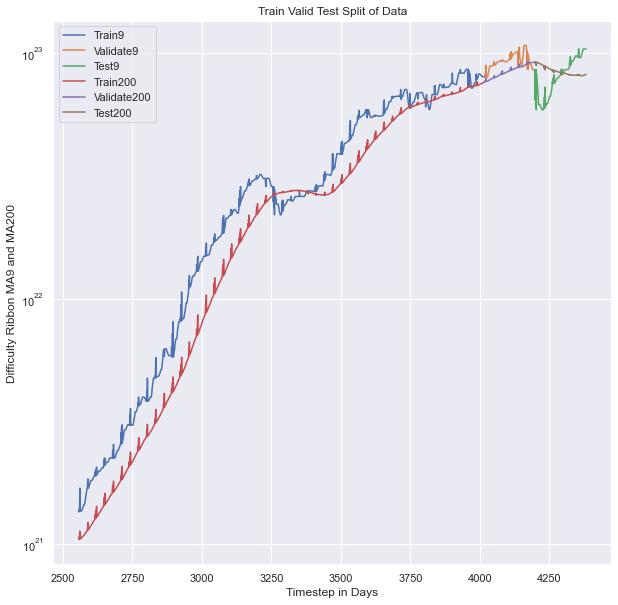

In [148]:
#LI PLOTTO INSIEME PER VEDERLI SOVRAPPOSTI
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train9, label = 'Train9')
plt.plot(x_valid9, label = 'Validate9')
plt.plot(x_test9, label = 'Test9')
plt.plot(x_train200, label = 'Train200')
plt.plot(x_valid200, label = 'Validate200')
plt.plot(x_test200, label = 'Test200')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Difficulty Ribbon MA9 and MA200')
plt.xlabel('Timestep in Days')
plt.yscale('log') #COMMENTARE PER VEDERE SCALA NORMALE
plt.legend()


In [149]:
len(x_train9.index)

1461

In [150]:
len(x_train200.index)

1461

In [151]:
# Lets create a dictionary to store all of our model training scores to view later
model_mae_scores = {}

# Base Model - Naive Forecasting

A naive forecast is naive because it takes the price from the day before and uses that price for the prediction of tomorrow. This is suprisingly effecting in this scenario due to the relatively due to autocorrelation. The price of tomorrow is dependent on the price today. Tomorrow's market open price is very close to the price of today's close.


Text(0.5, 1.0, 'Difficulty Ribbon')

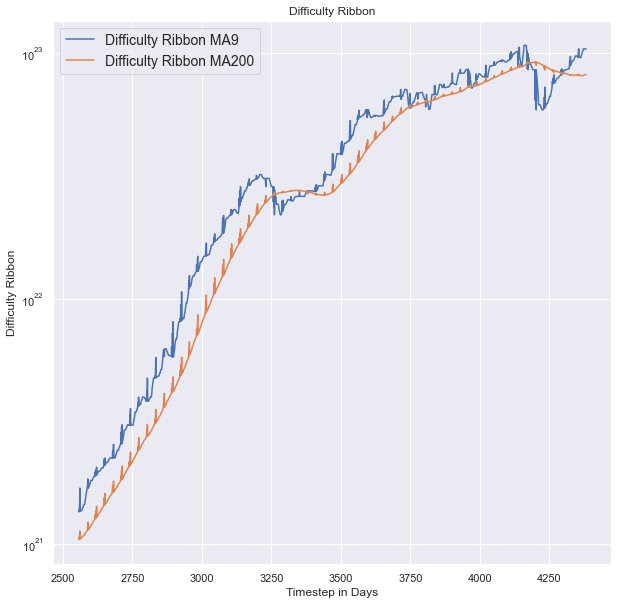

In [152]:
# Plot chart with all details untouched
def plot_series(time, series, format="-", start=0, end=None, label=None):
    """[Plot the series data over a time range]
    Args:
        time (data range): [The entire time span of the data in range format]
        series ([integers]): [Series value corresponding to its point on the time axis]
        format (str, optional): [Graph type]. Defaults to "-".
        start (int, optional): [Time to start time series data]. Defaults to 0.
        end ([type], optional): [Where to stop time data]. Defaults to None.
        label ([str], optional): [Label name of series]. Defaults to None.
    """
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
plot_series(time=difficultyh.index,series=difficultyh["Difficulty Ribbon/o/ma9"], label = 'Difficulty Ribbon MA9')
plot_series(time=difficultyh.index,series=difficultyh["Difficulty Ribbon/o/ma200"], label = 'Difficulty Ribbon MA200')
plt.ylabel('Difficulty Ribbon')
plt.xlabel('Timestep in Days')
plt.yscale('log')
plt.title('Difficulty Ribbon')

In [153]:
naive_forecast9 = series9[test_split_index9-1 :-1]

Text(0.5, 1.0, 'Hash rate Forecast vs Actual')

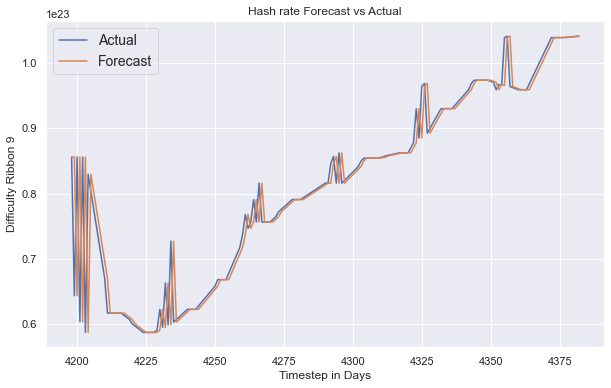

In [154]:
plt.figure(figsize=(10, 6))
plot_series(x_test9.index, x_test9, label="Actual")
plot_series(x_test9.index, naive_forecast9, label="Forecast")
plt.ylabel('Difficulty Ribbon 9')
plt.xlabel('Timestep in Days')
plt.title('Hash rate Forecast vs Actual')

In [155]:
naive_forecast200 = series200[test_split_index200-1 :-1]

Text(0.5, 1.0, 'Difficulty Ribbon Forecast vs Actual')

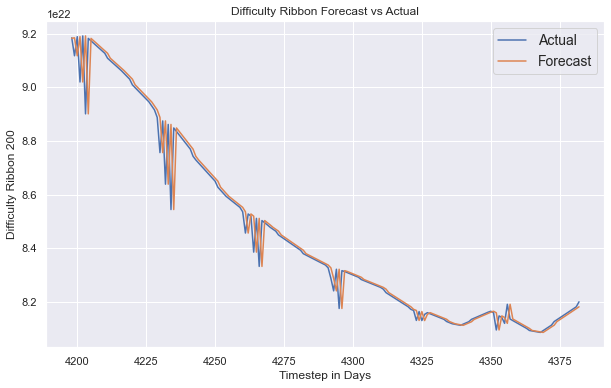

In [156]:
plt.figure(figsize=(10, 6))
plot_series(x_test200.index, x_test200, label="Actual")
plot_series(x_test200.index, naive_forecast200, label="Forecast")
plt.ylabel('Difficulty Ribbon 200')
plt.xlabel('Timestep in Days')
plt.title('Difficulty Ribbon Forecast vs Actual')

## Calculate Error in Naive Model

In [157]:
# Alternative way to show MAE to stay consistent with what we will be doing later
naive_forecast_mae9 = mean_absolute_error(x_test9, naive_forecast9)
model_mae_scores['naive9'] = naive_forecast_mae9

naive_forecast_mae200 = mean_absolute_error(x_test200, naive_forecast200)
model_mae_scores['naive200'] = naive_forecast_mae200

# view the dictionary of mae scores
model_mae_scores

{'naive9': 1.8456794211729917e+21, 'naive200': 2.814266532653555e+20}

In [158]:
# Show first 3 values of our forecast
print(naive_forecast9.values[:3])

# Show first 3 values of validation data
print(x_test9.values[:3])

# Calculate and show first 3 values of the calculated error (MAE)
print('*'*100)
print(np.abs(naive_forecast9[:3].values - x_test9[:3].values))

[8.56106856e+22 8.56106856e+22 6.43467211e+22]
[8.56106856e+22 6.43467211e+22 8.56106856e+22]
****************************************************************************************************
[0.00000000e+00 2.12639645e+22 2.12639645e+22]


In [159]:
# Show first 3 values of our forecast
print(naive_forecast200.values[:3])

# Show first 3 values of validation data
print(x_test200.values[:3])

# Calculate and show first 3 values of the calculated error (MAE)
print('*'*100)
print(np.abs(naive_forecast200[:3].values - x_test200[:3].values))

[9.18229129e+22 9.18395696e+22 9.11704939e+22]
[9.18395696e+22 9.11704939e+22 9.18833408e+22]
****************************************************************************************************
[1.66566628e+19 6.69075628e+20 7.12846902e+20]


ADESSO VADO A CREARE 2 MODELLI: 20 DAY E 5 DAY MOVING AVERAGE. MOTIVO SARA' ANCHE SPIEGATO NELLE CELLE SEGUENTI, TUTTAVIA FACCIO UNA PRECISAZIONE
- IL MODELLO 5MA SERVE A MODELLARE I 5 GIORNI DELLA SETTIMANA, IN QUANTO LA BORSA E' APERTA DA LUNEDI' A VENERDI', MENTRE GLI ALTRI GIORNI CHIUDE. 
- IL MODELLO 20MA E' COME IL PRECEDENTE, PERO' MENSILE, QUINDI MODELLA I 20 GIORNI IN CUI LA BORSA E' APERTA IN UN MESE.

TUTTO QUESTO NON VALE PER BITCOIN E CRYPTO, IN QUANTO E' SEMPRE POSSIBILE TRADARLI, OGNI ISTANTE.
IN OGNI CASO CI STA FARE QUESTA ANALISI, IN QUANTO MAGARI LA BORSA POTREBBE INFLUENZARE ANCHE LE CRYPTO

# Monthly Moving Average Model (20 Day MA) DA SISTEMARE

Moving Averages are not true prediction models, however it is an important topic to demonstrate. When you hear someone talk about how they want to "de-trend" or "smooth" data they are usually talking about implementing some sort of moving average. There are multiple moving average types with the most common being simple and exponential. Simple is just the average price over the desired time span. Exponential is a little more complicated as it provides a weight factor to each time step in the window. The weights are applied to make the more recent time steps more important that the later time steps. This allows the moving average to respond much more quickly to abrupt changes.

ValueError: x and y must have same first dimension, but have shapes (185,) and (205,)

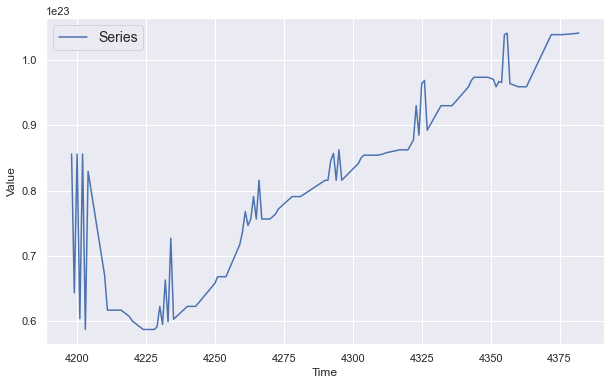

In [163]:
# Choose a window size for the moving average
window = 20

# Create a moving average over the entire dataset
moving_avg9 = difficultyh["Difficulty Ribbon/o/ma9"].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast9 = moving_avg9.values[test_split_index9 - window:difficultyh.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test9.index, x_test9, label="Series")
plot_series(x_test9.index, moving_avg_forecast9, label="Moving average (20 days)")
plt.ylabel('Difficulty Ribbon MA9')
plt.xlabel('Timestep in Days')
plt.title('SMA20 vs Actual')



# Create a moving average over the entire dataset
moving_avg200 = difficultyh["Difficulty Ribbon/o/ma200"].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast200 = moving_avg200.values[test_split_index200 - window:difficultyh.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test200.index, x_test200, label="Series")
plot_series(x_test200.index, moving_avg_forecast200, label="Moving average (20 days)")
plt.ylabel('Difficulty Ribbon MA200')
plt.xlabel('Timestep in Days')
plt.title('SMA20 vs Actual')



In [28]:
ma_20 = mean_absolute_error(x_test, moving_avg_forecast)

model_mae_scores['SMA 20'] = ma_20
model_mae_scores

{'naive': 1.3025434603123286e+19, 'SMA 20': 1.7718263902870979e+19}

# Weekly Moving Average (5 day MA) DA SISTEMARE

I have modeled a 20 day moving average and a 5 day moving average. This is because there are only 5 trading days a week which means 20 trading in a month. So these two moving averages show the weekly trend and the monthly trends of the S&P500. These moving averages are typically used to generate trading signals. For example, if the 5 SMA overtakes the 20 SMA that means the price is in a recent up trend and you may want to play that momentum going forward.

ValueError: x and y must have same first dimension, but have shapes (185,) and (190,)

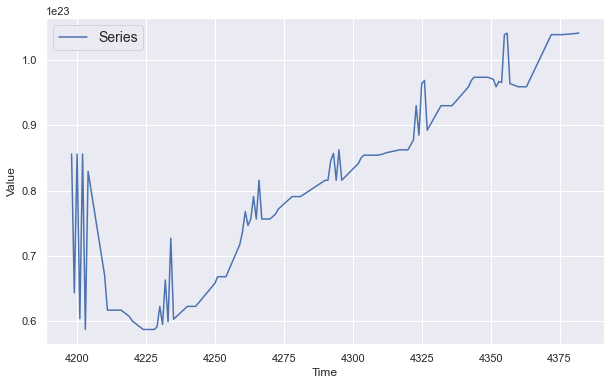

In [168]:
# Choose a window size for the moving average
window = 5

# Create a moving average over the entire dataset
moving_avg9 = difficultyh["Difficulty Ribbon/o/ma9"].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast9 = moving_avg9.values[test_split_index9 - window:difficultyh.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test9.index, x_test9, label="Series")
plot_series(x_test9.index, moving_avg_forecast9, label="Moving average (5 days)")
plt.ylabel('Difficulty Ribbon M9')
plt.xlabel('Timestep in Days')
plt.title('SMA5 Forecast vs Actual')

# Create a moving average over the entire dataset
moving_avg200 = difficultyh["Difficulty Ribbon/o/ma200"].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast200 = moving_avg200.values[test_split_index200 - window:difficultyh.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test200.index, x_test200, label="Series")
plot_series(x_test200.index, moving_avg_forecast200, label="Moving average (5 days)")
plt.ylabel('Difficulty Ribbon MA200')
plt.xlabel('Timestep in Days')
plt.title('SMA5 Forecast vs Actual')

In [169]:
# Calculate MAE
ma_5 = mean_absolute_error(x_test, moving_avg_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['SMA 5'] = ma_5
model_mae_scores

NameError: name 'moving_avg_forecast' is not defined

# ARIMA

Step 1: Is the data stationary?
Use Augmented Dickey Fuller test to determine if the data is stationary

- Failure to reject the null hypothesis means the data is not stationary

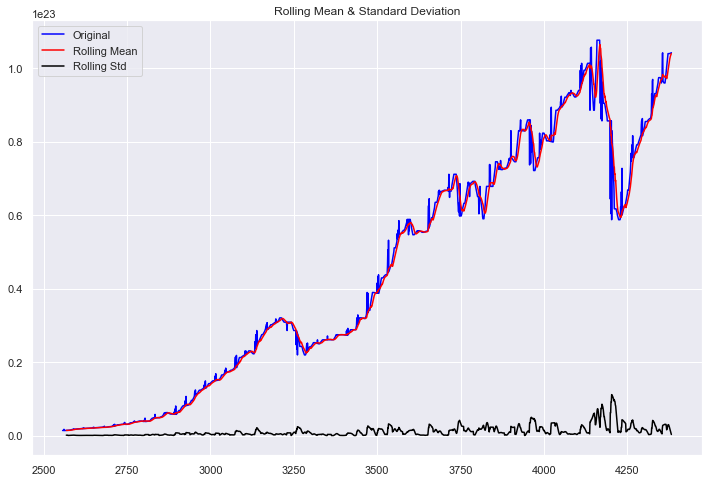

Results of Dickey-Fuller Test:
p-value = 0.9985. The series is likely non-stationary.
Test Statistic                    1.911959
p-value                           0.998547
#Lags Used                        3.000000
Number of Observations Used    1822.000000
Critical Value (1%)              -3.433944
Critical Value (5%)              -2.863128
Critical Value (10%)             -2.567615
dtype: float64


In [171]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
test_stationarity(series9)


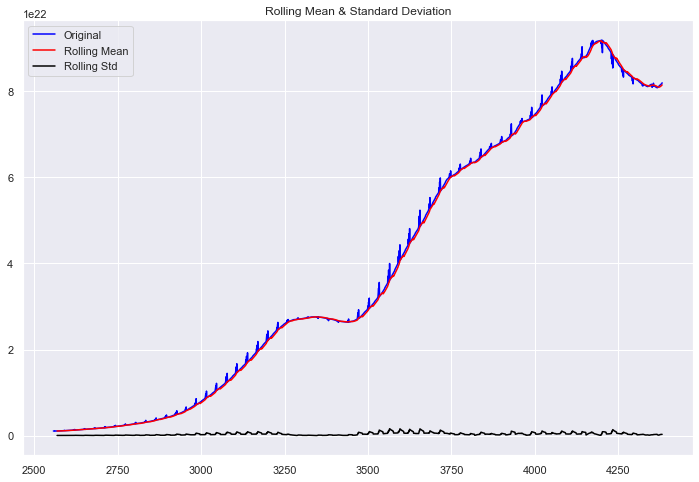

Results of Dickey-Fuller Test:
p-value = 0.9990. The series is likely non-stationary.
Test Statistic                    2.385404
p-value                           0.999003
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


In [172]:
test_stationarity(series200)

The p-value is obtained is greater than significance level of 0.05 in both cases and the ADF statistic is higher than any of the critical values.

Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary. Since our data is not stationary

# Step 2 Differencing

We must convert our non-stationary data to stationary data using the differencing method. This means we take the value at time (t) and subtract the value at time (t-1) to get the difference. This difference is also the calculated return over that period. Since our time steps are in days this differencing is the daily return.

In [173]:
# Get the difference of each Adj Close point
difficulty9_diff_1 = series9.diff()
difficulty9_diff_1.dropna(inplace=True)

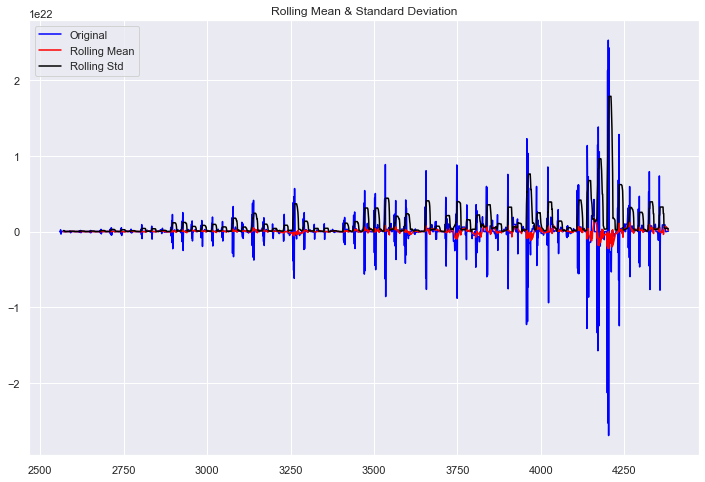

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -27.691842
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    1822.000000
Critical Value (1%)              -3.433944
Critical Value (5%)              -2.863128
Critical Value (10%)             -2.567615
dtype: float64


In [174]:
# Plot the tsla Adj Close 1st order difference
test_stationarity(difficulty9_diff_1)

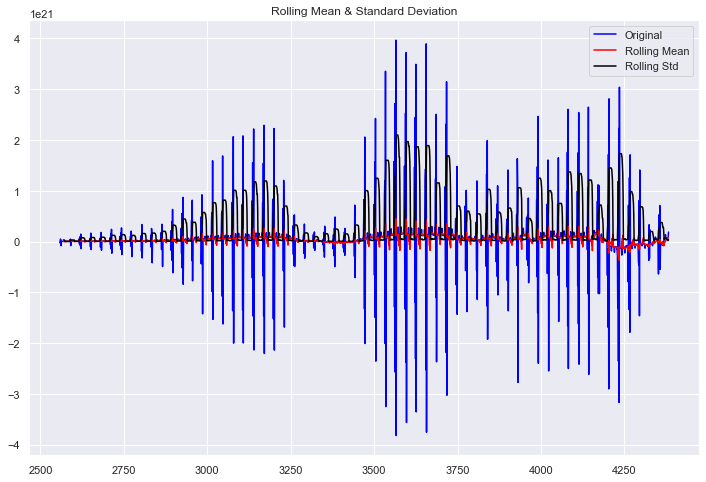

Results of Dickey-Fuller Test:
p-value = 0.0007. The series is likely stationary.
Test Statistic                   -4.174356
p-value                           0.000728
#Lags Used                       20.000000
Number of Observations Used    1804.000000
Critical Value (1%)              -3.433980
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567624
dtype: float64


In [175]:
# Get the difference of each Adj Close point
difficulty200_diff_1 = series200.diff()
difficulty200_diff_1.dropna(inplace=True)

# Plot the tsla Adj Close 1st order difference
test_stationarity(difficulty200_diff_1)

The p-value is obtained is less than significance level of 0.05 and the ADF statistic is lower than any of the critical values.

We reject the null hypothesis. So, the time series is in fact stationary.

# Step 3: Autocorrelation and Partial autocorrelation
Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. The difference between autocorrelation and partial autocorrelation can be difficult and confusing for beginners to time series forecasting.

Autocorrelation is the correlation between points at time t (Pₜ) and the point at(Pₜ₋₁). Partial autocorrelation is the point at time t (Pₜ) and the point (Pₜ₋ₖ) where k is any number of lags. Partial autocorrelation ignores all of the data in between both points.

In terms of a movie theater’s ticket sales, autocorrelation determines the relationship of today’s ticket sales and yesterday’s ticket sales. In comparison, partial autocorrelation defines the relationship of this Friday’s ticket sales and last Friday’s ticket sales.

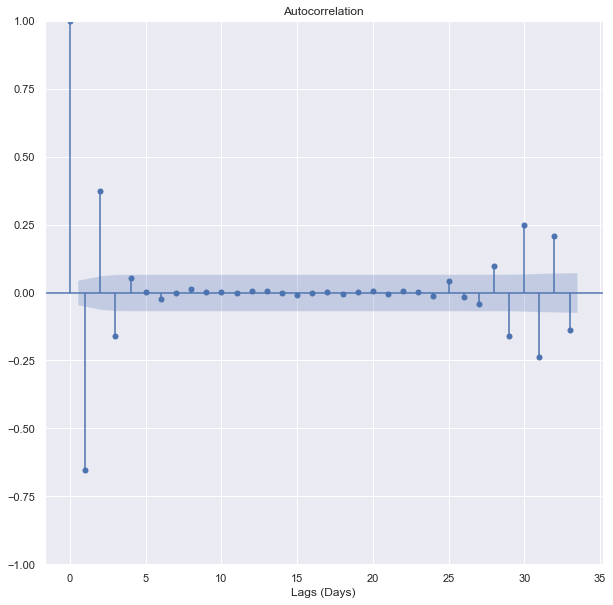

In [176]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(difficulty9_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


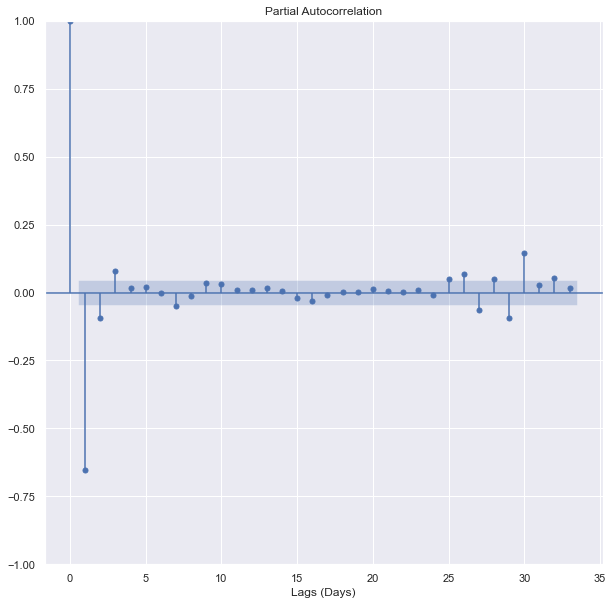

In [177]:
plot_pacf(difficulty9_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

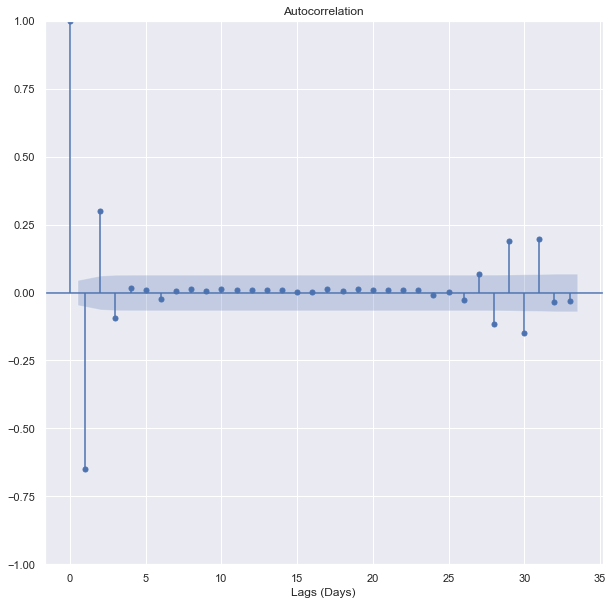

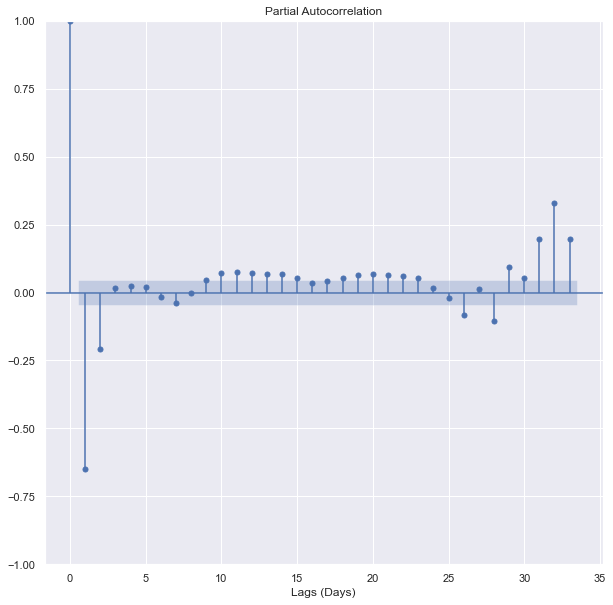

In [178]:
plot_acf(difficulty200_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

plot_pacf(difficulty200_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

Per 9 mi aspetto un (2,1,1) o simile e per 200 mi aspetto un (2,1,2) o simile

- Let’s start with the Autocorrelation plot. The important detail of these plots is the first lag. If the first lag is positive, we use an autoregressive (AR) model, and if the first lag is negative, we use a moving average (MA) plot. Since the first lag is negative, we will use the 1st lag as a moving average point.

- For the PACF plot, at lag one, which is negatively correlated, we will use an AR factor of 1 as well. If you have trouble determining how what lags are the best to use, feel free to experiment, and watch the AIC. The lower the AIC, the better.

- The ARIMA model takes three main inputs into the “order” argument. Those arguments are ‘p’ for the AR term, ‘d’ for the differencing term, ‘q’ for the MA term.

### Testing different arima models

------------- Auto SARIMA --------------- 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=145523.832, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=146125.162, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=145552.224, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=145640.413, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=146125.640, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=145522.009, Time=0.15 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=145523.836, Time=0.36 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=145525.831, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=145639.846, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=145550.232, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=145492.813, Time=0.40 sec
 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=145494.673, Time=0.93 sec
 ARIMA(2,1,1)(0,0,1)[7] intercept   : AIC=145494.669, Time=1.09 sec
 ARIMA(2,1,1)(1,0,1)[7] inter

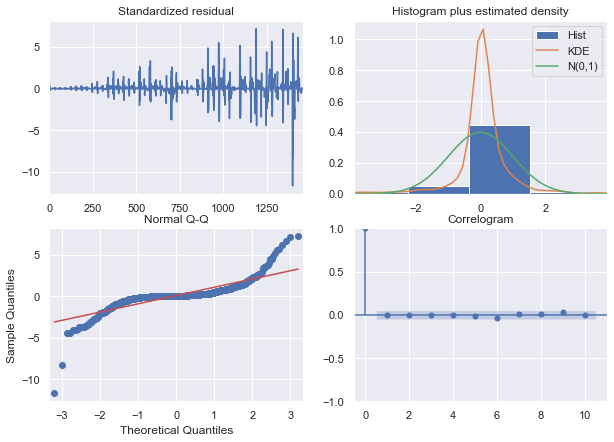

In [179]:
def model_auto_sarimax(y, seasonality, seasonal_flag, exogenous_variable):
    
    # Train model
    model = pm.auto_arima(x_train, exogenous=exogenous_variable, 
                          start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = input_seasonality, 
                          start_P = 0, seasonal = seasonal_flag, 
                          d = None, max_D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  stepwise = True, 
                          max_order=12)
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

def model_manual_sarima(y, order, seasonal_order):
    
    # Train model
    model = SARIMAX(y, order = order, seasonal_order = seasonal_order).fit()
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

def model_simple_exponential_smoothing(y):
    
    # Train model
    model = SimpleExpSmoothing(np.asarray(y)).fit(smoothing_level=0.6,optimized=False)
    
    # Model summary 
    print(model.summary())
    
    return model


------------- Auto SARIMA --------------- 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=145523.832, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=146125.162, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=145552.224, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=145640.413, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=146125.640, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=145522.009, Time=0.20 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=145523.836, Time=0.54 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=145525.831, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=145639.846, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=145550.232, Time=0.51 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=145492.813, Time=2.55 sec
 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=145494.673, Time=1.05 sec
 ARIMA(2,1,1)(0,0,1)[7] intercept   : AIC=145494.669, Time=0.87 sec
 ARIMA(2,1,1)(1,0,1)[7] inter

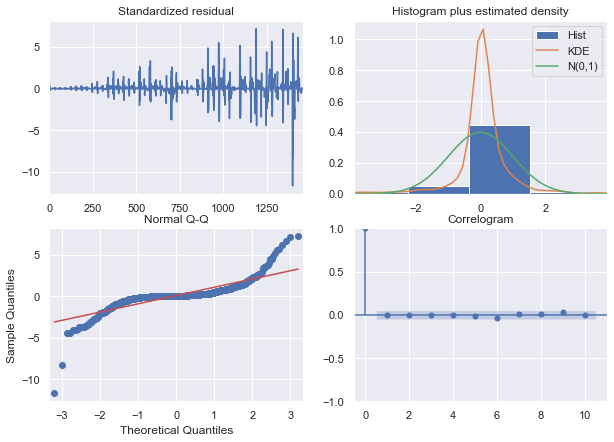

In [180]:
#per 9
# Forecasting algorithm
input_ts_algo = 'auto_sarima' # choose the forecasting algorithm from 'auto_arima', 'auto_sarima', 'auto_sarimax', 'manual_sarima', 'simple_exponential_smoothing' and 'holt_winters'


input_seasonality = 7


from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
# Get actual values
actuals = x_test9.reset_index(drop = True)

# Select the algorithm according to the input provided
if input_ts_algo == 'auto_arima':
    
    print("------------- Auto ARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train9, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarima':
    
    print("------------- Auto SARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train9, seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarimax':
    
    print("------------- Auto SARIMAX --------------- \n")
    model = model_auto_sarimax(y = x_train9, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))

elif input_ts_algo == 'manual_sarima':
    input_order = (3,1,0)
    input_seasonal_order = (2,1,1,7)
    print("------------- Manual SARIMA --------------- \n")
    model = model_manual_sarima(y = x_train9, order = input_order, seasonal_order = input_seasonal_order)

elif input_ts_algo == 'simple_exponential_smoothing':
    
    print("------------- Simple Exponential Smoothing --------------- \n")
    model = model_simple_exponential_smoothing(y = x_train9)

------------- Auto SARIMA --------------- 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=145523.832, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=146125.162, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=145552.224, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=145640.413, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=146125.640, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=145522.009, Time=0.13 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=145523.836, Time=0.52 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=145525.831, Time=1.45 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=145639.846, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=145550.232, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=145492.813, Time=0.66 sec
 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=145494.673, Time=0.79 sec
 ARIMA(2,1,1)(0,0,1)[7] intercept   : AIC=145494.669, Time=0.91 sec
 ARIMA(2,1,1)(1,0,1)[7] inter

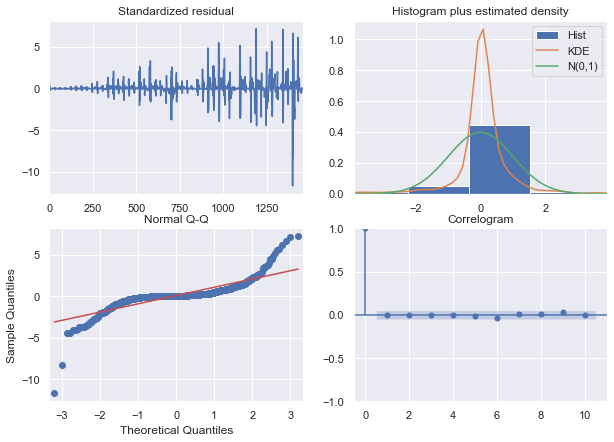

In [181]:
#per 200
# Forecasting algorithm
input_ts_algo = 'auto_sarima' # choose the forecasting algorithm from 'auto_arima', 'auto_sarima', 'auto_sarimax', 'manual_sarima', 'simple_exponential_smoothing' and 'holt_winters'


input_seasonality = 7


from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
# Get actual values
actuals = x_test200.reset_index(drop = True)

# Select the algorithm according to the input provided
if input_ts_algo == 'auto_arima':
    
    print("------------- Auto ARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train200, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarima':
    
    print("------------- Auto SARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train200, seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarimax':
    
    print("------------- Auto SARIMAX --------------- \n")
    model = model_auto_sarimax(y = x_train200, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))

elif input_ts_algo == 'manual_sarima':
    input_order = (3,1,0)
    input_seasonal_order = (2,1,1,7)
    print("------------- Manual SARIMA --------------- \n")
    model = model_manual_sarima(y = x_train200, order = input_order, seasonal_order = input_seasonal_order)

elif input_ts_algo == 'simple_exponential_smoothing':
    
    print("------------- Simple Exponential Smoothing --------------- \n")
    model = model_simple_exponential_smoothing(y = x_train200)

Abbiamo trovato che il miglior modello MA9 è ARIMA(3,1,1)(0,0,0)[7] e anche per MA200 ARIMA(3,1,1)(0,0,0)[7]

In [182]:
import statsmodels.api as sm

# fit model
difficulty9_arima = sm.tsa.arima.ARIMA(x_train9, order=(3,1,1), seasonal_order=(0,0,0,7))
difficulty9_arima_fit = difficulty9_arima.fit()
print(difficulty9_arima_fit.summary())


# fit model
difficulty200_arima = sm.tsa.arima.ARIMA(x_train200, order=(3,1,1), seasonal_order=(0,0,0,7))
difficulty200_arima_fit = difficulty200_arima.fit()
print(difficulty200_arima_fit.summary())

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                  SARIMAX Results                                  
Dep. Variable:     Difficulty Ribbon/o/ma9   No. Observations:                 1461
Model:                      ARIMA(3, 1, 1)   Log Likelihood              -72733.670
Date:                     Mon, 10 Oct 2022   AIC                         145477.340
Time:                             15:18:22   BIC                         145503.771
Sample:                                  0   HQIC                        145487.200
                                    - 1461                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2370      0.091     -2.606      0.009      -0.415      -0.059
ar.L2          0.1893      0.059      3.187      0.001       0.073       0.306
ar.L3       

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                   SARIMAX Results                                   
Dep. Variable:     Difficulty Ribbon/o/ma200   No. Observations:                 1461
Model:                        ARIMA(3, 1, 1)   Log Likelihood              -71346.086
Date:                       Mon, 10 Oct 2022   AIC                         142702.173
Time:                               15:18:23   BIC                         142728.604
Sample:                                    0   HQIC                        142712.032
                                      - 1461                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1682      0.011     15.307      0.000       0.147       0.190
ar.L2          0.5431      0.007     78.386      0.000       0.530       0.

NormaltestResult(statistic=509.298037169844, pvalue=2.5546794027760386e-111)
This distribution is not a normal distribution


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


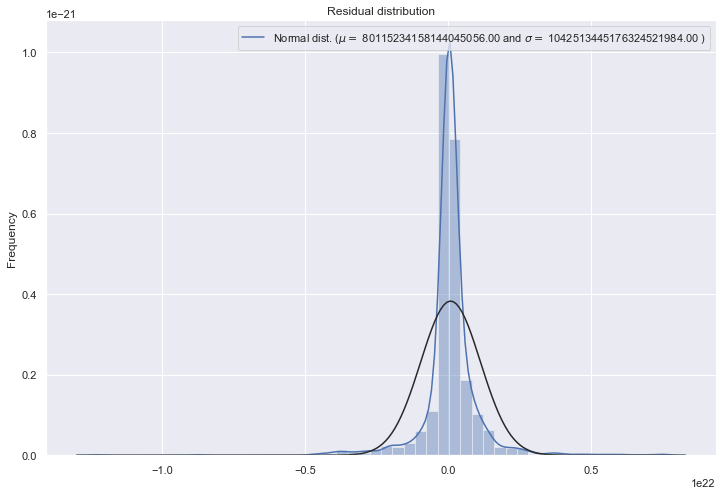

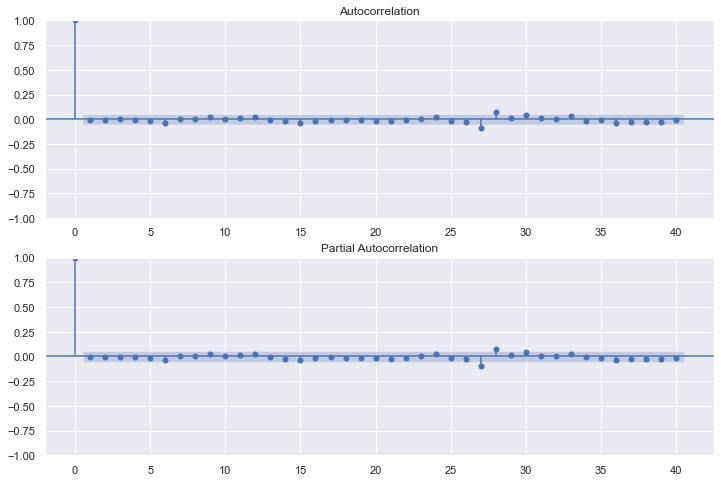

In [183]:
from scipy import stats
import statsmodels.api as sm
from scipy.stats import normaltest

residuals = difficulty9_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

NormaltestResult(statistic=398.02700838480996, pvalue=3.711361899515765e-87)
This distribution is not a normal distribution


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


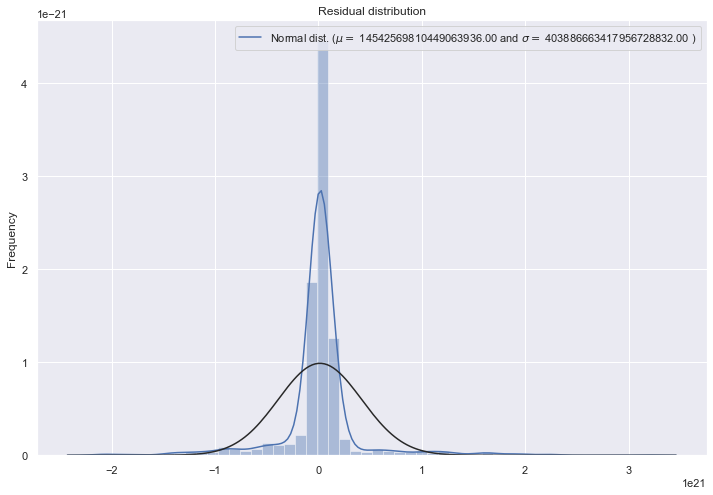

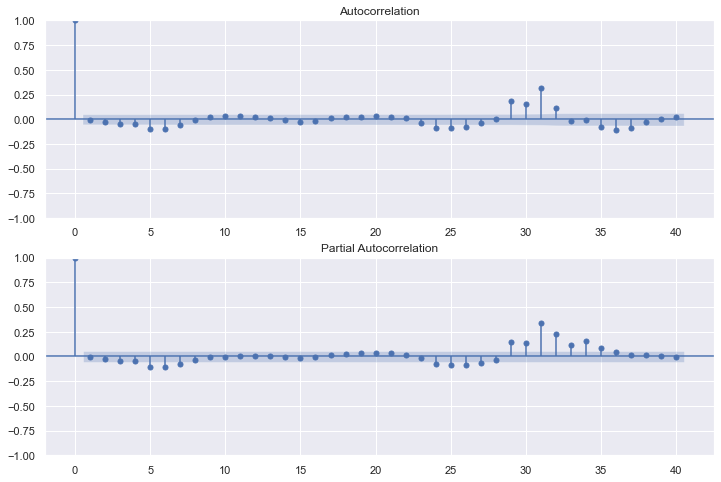

In [184]:
from scipy import stats
import statsmodels.api as sm
from scipy.stats import normaltest

residuals = difficulty200_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

# Step 4: Building the Arima Model and Forecasting
Now that we have experimented and found our prefered model order of (3,1,1)(0,0,0,7) lets build the model and get some forecasts.

This cell takes a while to run. Be careful. We have stored the model predictions using a magic method so we do not have to re-run this time consuming cell everytime.

Ci mette parecchio a calcolare questa cella giù. Se si vuole risparmiare tempo allora bisogna abbassare il numero di data points da predire

In [189]:
# Create list of x train valuess
history9 = [x for x in x_train9]

# establish list for predictions
model9_predictions = []

# Count number of test data points
N_test_observations9 = len(x_test9)

# loop through every data point
for time_point in list(x_test9.index[-N_test_observations9:]):
    model9 = sm.tsa.arima.ARIMA(history9, order=(3,1,1), seasonal_order=(0,0,0,7))
    model9_fit = model9.fit()
    output9 = model9_fit.forecast()
    yhat9 = output9[0]
    model9_predictions.append(yhat9)
    true_test_value9 = x_test9[time_point]
    history9.append(true_test_value9)
    
    
# Create list of x train valuess
history200 = [x for x in x_train200]

# establish list for predictions
model200_predictions = []

# Count number of test data points
N_test_observations200 = len(x_test200)

# loop through every data point
for time_point in list(x_test200.index[-N_test_observations200:]):
    model200 = sm.tsa.arima.ARIMA(history200, order=(3,1,1), seasonal_order=(0,0,0,7))
    model200_fit = model200.fit()
    output200 = model200_fit.forecast()
    yhat200 = output200[0]
    model200_predictions.append(yhat200)
    true_test_value200 = x_test200[time_point]
    history200.append(true_test_value200)
        
MAE_error9 = mean_absolute_error(x_test9, model9_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error9))

MAE_error200 = mean_absolute_error(x_test200, model200_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error200))

%store model9_predictions
%store model200_predictions

Testing Mean Squared Error is 1.7419794506316673e+21
Testing Mean Squared Error is 4.110312337389515e+20
Stored 'model9_predictions' (list)
Stored 'model200_predictions' (list)


In [190]:
output9
output200

array([8.17942682e+22])

In [191]:
# %store model_predictions
%store -r model9_predictions

# Check to see if it reloaded
model9_predictions[:5]

[8.009459735508965e+22,
 8.194372527130302e+22,
 7.890017469515607e+22,
 7.312875140777671e+22,
 7.58138288670307e+22]

In [192]:
# %store model_predictions
%store -r model200_predictions

# Check to see if it reloaded
model200_predictions[:5]

[7.634265516886256e+22,
 7.952447090169026e+22,
 9.138121332018896e+22,
 9.227186513070109e+22,
 9.098933467105402e+22]

In [193]:
model9_predictions

[8.009459735508965e+22,
 8.194372527130302e+22,
 7.890017469515607e+22,
 7.312875140777671e+22,
 7.58138288670307e+22,
 6.72534039884095e+22,
 7.895098074511269e+22,
 6.37206779377533e+22,
 7.782755622818751e+22,
 8.244075975434189e+22,
 7.801790718000655e+22,
 7.482259884420556e+22,
 7.195349456768375e+22,
 6.913861155440253e+22,
 6.578870530709143e+22,
 6.1308915688436014e+22,
 6.082352920708871e+22,
 6.139112303202191e+22,
 6.15860114768519e+22,
 6.165285562477757e+22,
 6.161564136124222e+22,
 6.1305029543235965e+22,
 6.0938055034766166e+22,
 6.053462604861845e+22,
 5.994123744714948e+22,
 5.95586860423633e+22,
 5.9254377857215655e+22,
 5.8933643831114335e+22,
 5.8667902585665e+22,
 5.8659037715024354e+22,
 5.8700342201366365e+22,
 5.871511644055186e+22,
 5.879272486837837e+22,
 5.968378305647449e+22,
 6.170768206710513e+22,
 6.125232181491184e+22,
 6.475739021977392e+22,
 6.3141915332954565e+22,
 6.977925248357837e+22,
 6.220671089163606e+22,
 5.9723659228638544e+22,
 6.08795263770

In [194]:
model9_predictions = np.array(model9_predictions).flatten()

# Calculate MAE
arima_mae9 = mean_absolute_error(x_test9, model9_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA9'] = arima_mae9

model200_predictions = np.array(model200_predictions).flatten()

# Calculate MAE
arima_mae200 = mean_absolute_error(x_test200, model200_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA9'] = arima_mae200

model_mae_scores

{'naive9': 1.8456794211729917e+21,
 'naive200': 2.814266532653555e+20,
 'ARIMA9': 4.110312337389515e+20}

- You may want to zoom in on the plot below to get a better view of the differences. To do this simply use the [:] slicing on x_test.index and model_predictions/x_test in the plt.plot() lines. I typically like to do [-100:] to get the last 100 values

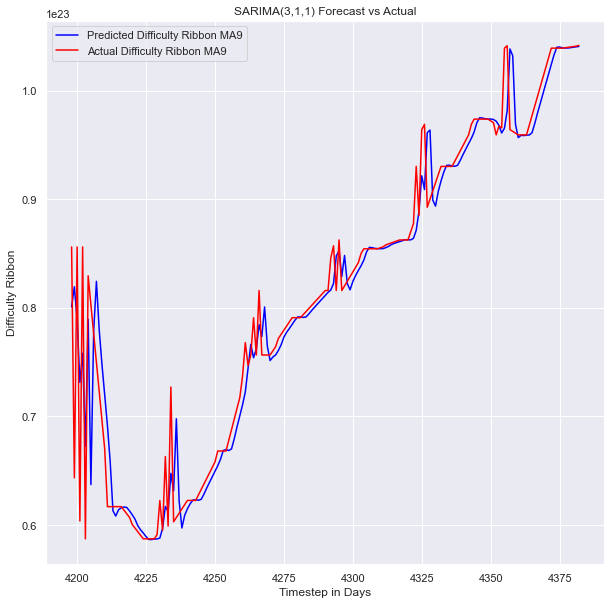

<Figure size 720x432 with 0 Axes>

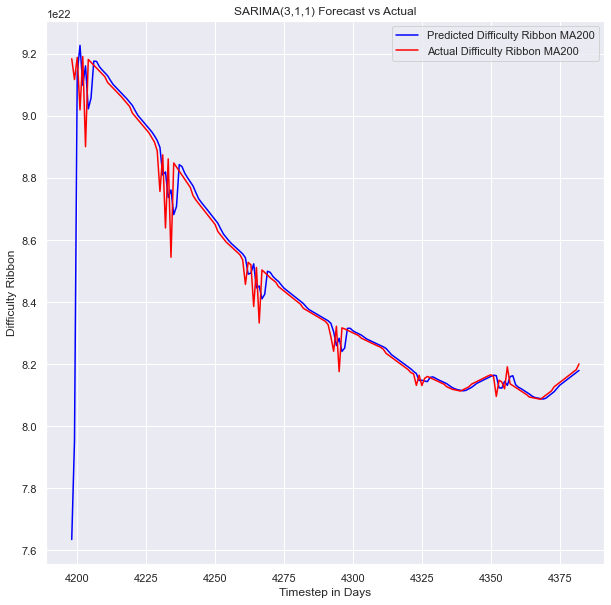

<Figure size 720x432 with 0 Axes>

In [195]:
# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test9.index[-N_test_observations9:], model9_predictions[-N_test_observations9:], color='blue',label='Predicted Difficulty Ribbon MA9')
plt.plot(x_test9.index[-N_test_observations9:], x_test9[-N_test_observations9:], color='red', label='Actual Difficulty Ribbon MA9')
plt.ylabel('Difficulty Ribbon')
plt.xlabel('Timestep in Days')
plt.title('SARIMA(3,1,1) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test200.index[-N_test_observations200:], model200_predictions[-N_test_observations200:], color='blue',label='Predicted Difficulty Ribbon MA200')
plt.plot(x_test200.index[-N_test_observations200:], x_test200[-N_test_observations200:], color='red', label='Actual Difficulty Ribbon MA200')
plt.ylabel('Difficulty Ribbon')
plt.xlabel('Timestep in Days')
plt.title('SARIMA(3,1,1) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [196]:
# Find the Error in the ARIMA Model
arima_error9 = model9_predictions - x_test9
arima_error200 = model200_predictions - x_test200

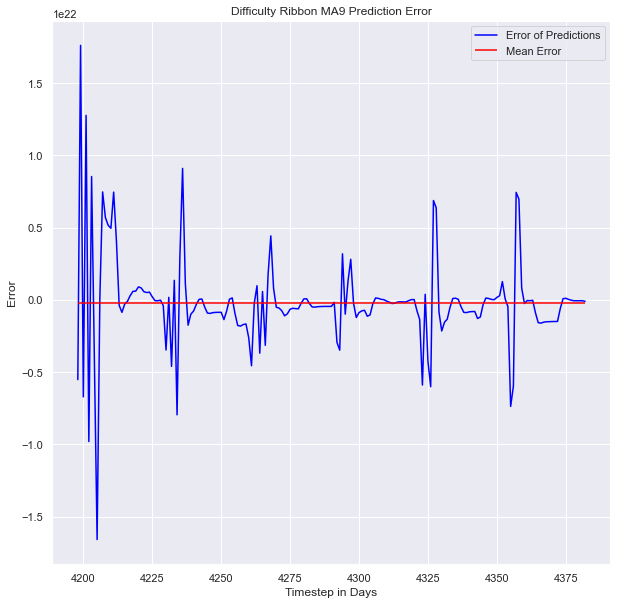

<Figure size 720x432 with 0 Axes>

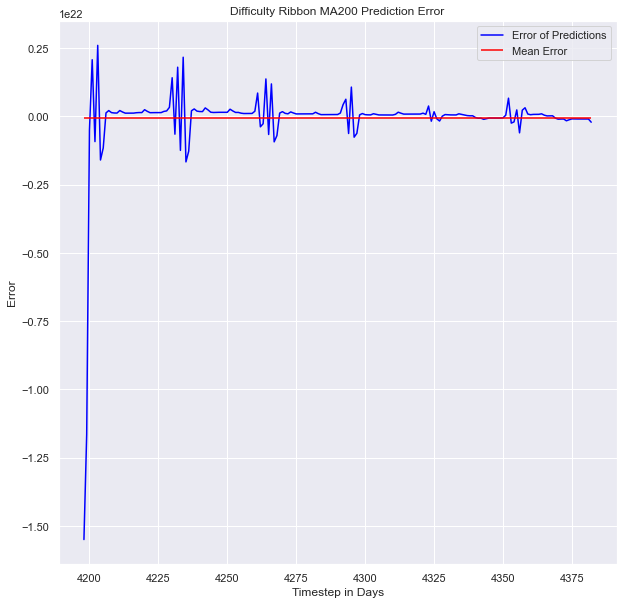

<Figure size 720x432 with 0 Axes>

In [197]:
plt.plot(x_test9.index, arima_error9, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error9),xmin=x_test9.index.min(),xmax=x_test9.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('Difficulty Ribbon MA9 Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

plt.plot(x_test200.index, arima_error200, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error200),xmin=x_test200.index.min(),xmax=x_test200.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('Difficulty Ribbon MA200 Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [198]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

{'naive9': 1.8456794211729917e+21,
 'naive200': 2.814266532653555e+20,
 'ARIMA9': 4.110312337389515e+20}

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

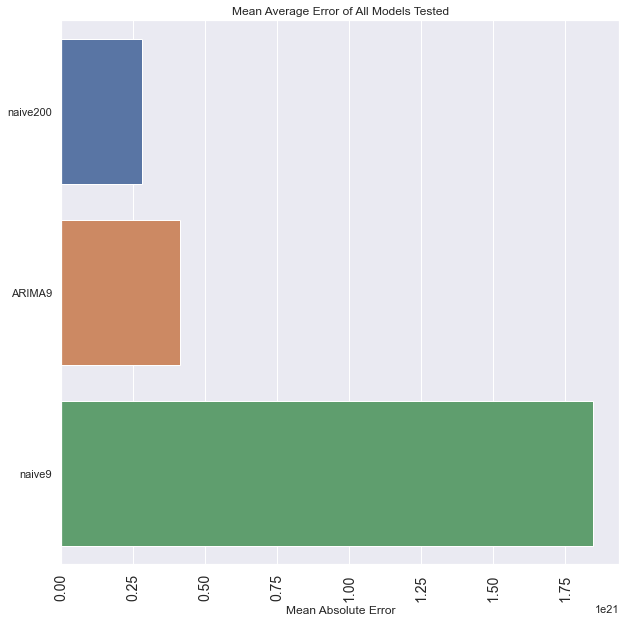

In [199]:
# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')

# LSTM

- LSTM stands for Long Short Term Memory
The LSTM cell contains an RNN cell inside (dense layer with a tanh activation function), but it has other attributes that allow it to remember patterns over a longer period of time. The LSTM contains a short-term state vector that is used from one time step to the next identical to the RNN cell.

Where LSTM cells differ is their Long-Term State vector. This long term state vector undergoes a multipicative and additive operation at each time step.The long term state vector starts off with a "forget gate" which is simply a sigmoid activation on top of a dense layer which produces an output from 0 - 1. This means if the forget gate ourputs a value of 1 then the long term state vector remains unchanged. On the opposite end, if the output valuse of the dense layer is 0 the long term state vector is nullified. This helps adjust quickly to highly volatile environments. If we are in a steady uptrend and then we suddenly have a big drop in the market, the long term state vector will be erased so the model can readjust quickly.

The next gate is the input gate. The input gate is much like the forget gate, except it decides if the short term state vector gets added to the long term vector or is erased.

The last gate called the "output gate" decides what the next hidden state should be. It is important to know that this hidden state output is the prediction for the next time step. Here, the previous hidden state (previous cell output) amd current input are jammed together through sigmoid function. Then we take our newly modified long term state vector which has already passed through the forget and input gates, and apply a tanh function to it. Finally, multiple both the tanh output (long term state vector output) and the sigmoid function output (previous hidden state and new input at this time step) to what information the hidden state needs to carry to the next time step.

</br> To review, the Forget gate decides what is relevant to keep from prior steps. The input gate decides what information is relevant to add from the current step. The output gate determines what the next hidden state should be.

In [200]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [201]:
x_train9

2557    1.373629e+21
2558    1.350079e+21
2559    1.353674e+21
2560    1.446974e+21
2561    1.687764e+21
            ...     
4013    8.018776e+22
4014    8.018776e+22
4015    8.015408e+22
4016    8.012040e+22
4017    8.005304e+22
Name: Difficulty Ribbon/o/ma9, Length: 1461, dtype: float64

In [202]:
x_train9.shape

(1461,)

In [204]:
# Reshape values
x_train9_values = x_train9.values.reshape(-1, 1)
x_valid9_values = x_valid9.values.reshape(-1, 1)
x_test9_values = x_test9.values.reshape(-1, 1)

#  Create Scaler Object
x_train9_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train9 = x_train9_scaler.fit_transform(x_train9_values)

# Fit x_valid values
normalized_x_valid9 = x_train9_scaler.transform(x_valid9_values)

# Fit x_test values
normalized_x_test9 = x_train9_scaler.transform(x_test9_values)

# All values normalized to training data
spy_normalized_to_traindata9 = x_train9_scaler.transform(series9.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

In [205]:
# Reshape values
x_train200_values = x_train200.values.reshape(-1, 1)
x_valid200_values = x_valid200.values.reshape(-1, 1)
x_test200_values = x_test200.values.reshape(-1, 1)

#  Create Scaler Object
x_train200_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train200 = x_train200_scaler.fit_transform(x_train200_values)

# Fit x_valid values
normalized_x_valid200 = x_train200_scaler.transform(x_valid200_values)

# Fit x_test values
normalized_x_test200 = x_train200_scaler.transform(x_test200_values)

# All values normalized to training data
spy_normalized_to_traindata200 = x_train200_scaler.transform(series200.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

In [206]:
x_train9_values

array([[1.37362939e+21],
       [1.35007879e+21],
       [1.35367442e+21],
       ...,
       [8.01540834e+22],
       [8.01204035e+22],
       [8.00530436e+22]])

In [207]:
x_train9_values.shape

(1461, 1)

In [208]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

### Find the learning rate

In [209]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 20
train_set9 = sequential_window_dataset(normalized_x_train9, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set9, epochs=100,
                    callbacks=[lr_schedule, reset_states])

/usr/local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
73/73 [==============================] - 7s 23ms/step - loss: 0.0557 - mae: 0.2665 - lr: 1.0000e-05
Epoch 2/100
73/73 [==============================] - 1s 15ms/step - loss: 0.0308 - mae: 0.1938 - lr: 1.1220e-05
Epoch 3/100
73/73 [==============================] - 1s 18ms/step - loss: 0.0123 - mae: 0.1254 - lr: 1.2589e-05
Epoch 4/100
73/73 [==============================] - 2s 21ms/step - loss: 0.0026 - mae: 0.0600 - lr: 1.4125e-05
Epoch 5/100
73/73 [==============================] - 1s 19ms/step - loss: 0.0011 - mae: 0.0397 - lr: 1.5849e-05
Epoch 6/100
73/73 [==============================] - 1s 16ms/step - loss: 0.0010 - mae: 0.0377 - lr: 1.7783e-05
Epoch 7/100
73/73 [==============================] - 1s 20ms/step - loss: 8.5924e-04 - mae: 0.0341 - lr: 1.9953e-05
Epoch 8/100
73/73 [==============================] - 1s 17ms/step - loss: 7.2205e-04 - mae: 0.0305 - lr: 2.2387e-05
Epoch 9/100
73/73 [==============================] - 1s 15ms/step - loss: 6.1040e-04 - mae: 0.02

73/73 [==============================] - 1s 18ms/step - loss: 0.0191 - mae: 0.1055 - lr: 0.0398
Epoch 74/100
73/73 [==============================] - 1s 15ms/step - loss: 0.0119 - mae: 0.0683 - lr: 0.0447
Epoch 75/100
73/73 [==============================] - 1s 15ms/step - loss: 0.0175 - mae: 0.0877 - lr: 0.0501
Epoch 76/100
73/73 [==============================] - 2s 21ms/step - loss: 0.0813 - mae: 0.1883 - lr: 0.0562
Epoch 77/100
73/73 [==============================] - 1s 18ms/step - loss: 0.0291 - mae: 0.0905 - lr: 0.0631
Epoch 78/100
73/73 [==============================] - 1s 16ms/step - loss: 0.0225 - mae: 0.1043 - lr: 0.0708
Epoch 79/100
73/73 [==============================] - 1s 15ms/step - loss: 0.0476 - mae: 0.1649 - lr: 0.0794
Epoch 80/100
73/73 [==============================] - 1s 17ms/step - loss: 0.0382 - mae: 0.1258 - lr: 0.0891
Epoch 81/100
73/73 [==============================] - 1s 17ms/step - loss: 0.0402 - mae: 0.1146 - lr: 0.1000
Epoch 82/100
73/73 [============

(1e-05, 0.1, 0.0, 0.03)

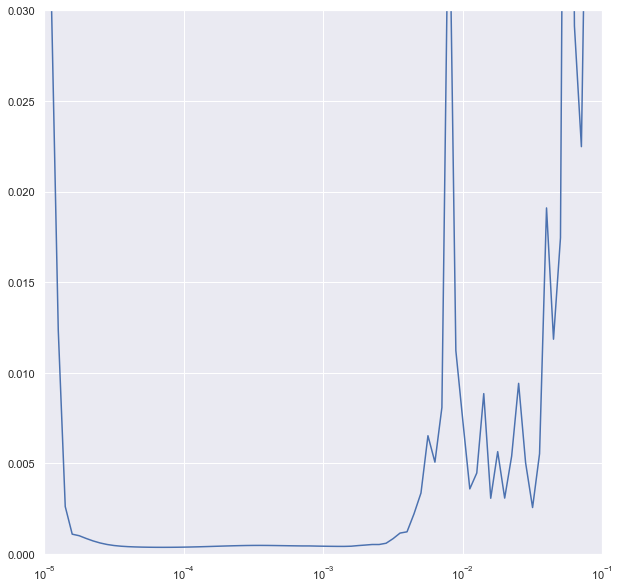

In [210]:
# Plot the learning rate chart
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 0.03])

In [211]:
#This is the best learning rate
history.history["loss"][history.history["loss"].index(min(history.history["loss"]))]
#Arrotondo a 0.00037

0.00037027933285571635

In [217]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 30
train_set = sequential_window_dataset(normalized_x_train9, window_size)
valid_set = sequential_window_dataset(normalized_x_valid9, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.Nadam(lr=0.00037)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

#set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

/usr/local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/500
     47/Unknown - 7s 22ms/step - loss: 0.0011 - mae: 0.0270 

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 38s 675ms/step - loss: 0.0012 - mae: 0.0279 - val_loss: 0.0025 - val_mae: 0.0593
Epoch 2/500
48/48 [==============================] - ETA: 0s - loss: 9.6243e-04 - mae: 0.0303

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 31s 664ms/step - loss: 9.6243e-04 - mae: 0.0303 - val_loss: 0.0012 - val_mae: 0.0330
Epoch 3/500
47/48 [============================>.] - ETA: 0s - loss: 4.7326e-04 - mae: 0.0197

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 28s 593ms/step - loss: 5.7758e-04 - mae: 0.0213 - val_loss: 0.0011 - val_mae: 0.0302
Epoch 4/500
48/48 [==============================] - ETA: 0s - loss: 5.1587e-04 - mae: 0.0193

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 29s 606ms/step - loss: 5.1587e-04 - mae: 0.0193 - val_loss: 0.0011 - val_mae: 0.0301
Epoch 5/500
48/48 [==============================] - 1s 23ms/step - loss: 4.8847e-04 - mae: 0.0195 - val_loss: 0.0011 - val_mae: 0.0311
Epoch 6/500
48/48 [==============================] - 1s 22ms/step - loss: 4.6437e-04 - mae: 0.0193 - val_loss: 0.0012 - val_mae: 0.0325
Epoch 7/500
48/48 [==============================] - 1s 23ms/step - loss: 4.4420e-04 - mae: 0.0190 - val_loss: 0.0012 - val_mae: 0.0342
Epoch 8/500
48/48 [==============================] - 1s 25ms/step - loss: 4.2707e-04 - mae: 0.0188 - val_loss: 0.0013 - val_mae: 0.0358
Epoch 9/500
48/48 [==============================] - 1s 26ms/step - loss: 4.1242e-04 - mae: 0.0187 - val_loss: 0.0013 - val_mae: 0.0374
Epoch 10/500
48/48 [==============================] - 1s 22ms/step - loss: 3.9975e-04 - mae: 0.0185 - val_loss: 0.0014 - val_mae: 0.0390
Epoch 11/500
48/48 [==============================] - 1s 

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 33s 707ms/step - loss: 3.0437e-04 - mae: 0.0174 - val_loss: 0.0011 - val_mae: 0.0344
Epoch 27/500
48/48 [==============================] - ETA: 0s - loss: 3.0070e-04 - mae: 0.0173

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 32s 684ms/step - loss: 3.0070e-04 - mae: 0.0173 - val_loss: 0.0010 - val_mae: 0.0330
Epoch 28/500
46/48 [===========================>..] - ETA: 0s - loss: 2.2611e-04 - mae: 0.0157

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 33s 703ms/step - loss: 2.9707e-04 - mae: 0.0172 - val_loss: 9.9447e-04 - val_mae: 0.0318
Epoch 29/500
46/48 [===========================>..] - ETA: 0s - loss: 2.2247e-04 - mae: 0.0156

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 38s 797ms/step - loss: 2.9344e-04 - mae: 0.0171 - val_loss: 9.4557e-04 - val_mae: 0.0305
Epoch 30/500
46/48 [===========================>..] - ETA: 0s - loss: 2.1877e-04 - mae: 0.0155

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 35s 753ms/step - loss: 2.8979e-04 - mae: 0.0171 - val_loss: 8.9948e-04 - val_mae: 0.0294
Epoch 31/500
48/48 [==============================] - ETA: 0s - loss: 2.8609e-04 - mae: 0.0170

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 42s 896ms/step - loss: 2.8609e-04 - mae: 0.0170 - val_loss: 8.5668e-04 - val_mae: 0.0282
Epoch 32/500
46/48 [===========================>..] - ETA: 0s - loss: 2.1115e-04 - mae: 0.0153

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 39s 833ms/step - loss: 2.8233e-04 - mae: 0.0168 - val_loss: 8.1754e-04 - val_mae: 0.0272
Epoch 33/500
46/48 [===========================>..] - ETA: 0s - loss: 2.0725e-04 - mae: 0.0152

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 47s 1s/step - loss: 2.7847e-04 - mae: 0.0167 - val_loss: 7.8235e-04 - val_mae: 0.0262
Epoch 34/500
48/48 [==============================] - ETA: 0s - loss: 2.7448e-04 - mae: 0.0166

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 59s 1s/step - loss: 2.7448e-04 - mae: 0.0166 - val_loss: 7.5131e-04 - val_mae: 0.0254
Epoch 35/500
48/48 [==============================] - ETA: 0s - loss: 2.7030e-04 - mae: 0.0164

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 60s 1s/step - loss: 2.7030e-04 - mae: 0.0164 - val_loss: 7.2455e-04 - val_mae: 0.0247
Epoch 36/500
48/48 [==============================] - ETA: 0s - loss: 2.6590e-04 - mae: 0.0163

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 35s 754ms/step - loss: 2.6590e-04 - mae: 0.0163 - val_loss: 7.0219e-04 - val_mae: 0.0242
Epoch 37/500
45/48 [===========================>..] - ETA: 0s - loss: 1.7890e-04 - mae: 0.0141

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 40s 852ms/step - loss: 2.6119e-04 - mae: 0.0161 - val_loss: 6.8429e-04 - val_mae: 0.0238
Epoch 38/500
47/48 [============================>.] - ETA: 0s - loss: 2.2573e-04 - mae: 0.0151

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 39s 826ms/step - loss: 2.5610e-04 - mae: 0.0159 - val_loss: 6.7076e-04 - val_mae: 0.0235
Epoch 39/500
46/48 [===========================>..] - ETA: 0s - loss: 1.8303e-04 - mae: 0.0141

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 56s 1s/step - loss: 2.5057e-04 - mae: 0.0157 - val_loss: 6.6136e-04 - val_mae: 0.0233
Epoch 40/500
48/48 [==============================] - ETA: 0s - loss: 2.4460e-04 - mae: 0.0154

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 50s 1s/step - loss: 2.4460e-04 - mae: 0.0154 - val_loss: 6.5544e-04 - val_mae: 0.0232
Epoch 41/500
46/48 [===========================>..] - ETA: 0s - loss: 1.7459e-04 - mae: 0.0137

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 34s 718ms/step - loss: 2.3831e-04 - mae: 0.0152 - val_loss: 6.5192e-04 - val_mae: 0.0231
Epoch 42/500
47/48 [============================>.] - ETA: 0s - loss: 2.0504e-04 - mae: 0.0141

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 38s 806ms/step - loss: 2.3194e-04 - mae: 0.0149 - val_loss: 6.4954e-04 - val_mae: 0.0231
Epoch 43/500
48/48 [==============================] - ETA: 0s - loss: 2.2582e-04 - mae: 0.0146

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 37s 777ms/step - loss: 2.2582e-04 - mae: 0.0146 - val_loss: 6.4714e-04 - val_mae: 0.0230
Epoch 44/500
47/48 [============================>.] - ETA: 0s - loss: 1.9504e-04 - mae: 0.0137

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 34s 723ms/step - loss: 2.2020e-04 - mae: 0.0144 - val_loss: 6.4411e-04 - val_mae: 0.0230
Epoch 45/500
48/48 [==============================] - ETA: 0s - loss: 2.1525e-04 - mae: 0.0142

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 34s 732ms/step - loss: 2.1525e-04 - mae: 0.0142 - val_loss: 6.4032e-04 - val_mae: 0.0229
Epoch 46/500
48/48 [==============================] - ETA: 0s - loss: 2.1100e-04 - mae: 0.0140

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 35s 749ms/step - loss: 2.1100e-04 - mae: 0.0140 - val_loss: 6.3587e-04 - val_mae: 0.0228
Epoch 47/500
46/48 [===========================>..] - ETA: 0s - loss: 1.5287e-04 - mae: 0.0125

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 34s 731ms/step - loss: 2.0741e-04 - mae: 0.0138 - val_loss: 6.3098e-04 - val_mae: 0.0227
Epoch 48/500
46/48 [===========================>..] - ETA: 0s - loss: 1.5057e-04 - mae: 0.0124

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 40s 840ms/step - loss: 2.0441e-04 - mae: 0.0137 - val_loss: 6.2591e-04 - val_mae: 0.0227
Epoch 49/500
46/48 [===========================>..] - ETA: 0s - loss: 1.4861e-04 - mae: 0.0123

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 39s 828ms/step - loss: 2.0194e-04 - mae: 0.0136 - val_loss: 6.2085e-04 - val_mae: 0.0227
Epoch 50/500
47/48 [============================>.] - ETA: 0s - loss: 1.7716e-04 - mae: 0.0128

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 39s 829ms/step - loss: 1.9991e-04 - mae: 0.0135 - val_loss: 6.1607e-04 - val_mae: 0.0227
Epoch 51/500
47/48 [============================>.] - ETA: 0s - loss: 1.7567e-04 - mae: 0.0128

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 27s 568ms/step - loss: 1.9827e-04 - mae: 0.0135 - val_loss: 6.1177e-04 - val_mae: 0.0228
Epoch 52/500
48/48 [==============================] - ETA: 0s - loss: 1.9695e-04 - mae: 0.0134

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 24s 504ms/step - loss: 1.9695e-04 - mae: 0.0134 - val_loss: 6.0807e-04 - val_mae: 0.0228
Epoch 53/500
47/48 [============================>.] - ETA: 0s - loss: 1.7359e-04 - mae: 0.0127

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 28s 599ms/step - loss: 1.9589e-04 - mae: 0.0134 - val_loss: 6.0535e-04 - val_mae: 0.0229
Epoch 54/500
48/48 [==============================] - ETA: 0s - loss: 1.9507e-04 - mae: 0.0133

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 38s 817ms/step - loss: 1.9507e-04 - mae: 0.0133 - val_loss: 6.0354e-04 - val_mae: 0.0229
Epoch 55/500
46/48 [===========================>..] - ETA: 0s - loss: 1.4280e-04 - mae: 0.0120

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 50s 1s/step - loss: 1.9442e-04 - mae: 0.0133 - val_loss: 6.0348e-04 - val_mae: 0.0230
Epoch 56/500
48/48 [==============================] - 1s 31ms/step - loss: 1.9394e-04 - mae: 0.0133 - val_loss: 6.0525e-04 - val_mae: 0.0230
Epoch 57/500
48/48 [==============================] - 2s 33ms/step - loss: 1.9369e-04 - mae: 0.0133 - val_loss: 6.1034e-04 - val_mae: 0.0230
Epoch 58/500
48/48 [==============================] - 2s 43ms/step - loss: 1.9334e-04 - mae: 0.0133 - val_loss: 6.2317e-04 - val_mae: 0.0230
Epoch 59/500
48/48 [==============================] - 1s 30ms/step - loss: 1.9403e-04 - mae: 0.0133 - val_loss: 6.3561e-04 - val_mae: 0.0231
Epoch 60/500
48/48 [==============================] - 1s 30ms/step - loss: 1.9258e-04 - mae: 0.0132 - val_loss: 7.3431e-04 - val_mae: 0.0248
Epoch 61/500
48/48 [==============================] - 1s 31ms/step - loss: 2.0213e-04 - mae: 0.0134 - val_loss: 6.3900e-04 - val_mae: 0.0262
Epoch 62/500
48/48 [=======

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


48/48 [==============================] - 65s 1s/step - loss: 4.5343e-04 - mae: 0.0197 - val_loss: 5.7270e-04 - val_mae: 0.0222
Epoch 65/500
48/48 [==============================] - 2s 38ms/step - loss: 2.6180e-04 - mae: 0.0149 - val_loss: 0.0011 - val_mae: 0.0382
Epoch 66/500
48/48 [==============================] - 2s 34ms/step - loss: 1.2992e-04 - mae: 0.0090 - val_loss: 0.0012 - val_mae: 0.0412
Epoch 67/500
48/48 [==============================] - 2s 34ms/step - loss: 1.3202e-04 - mae: 0.0093 - val_loss: 0.0012 - val_mae: 0.0417
Epoch 68/500
48/48 [==============================] - 2s 34ms/step - loss: 1.3169e-04 - mae: 0.0093 - val_loss: 0.0012 - val_mae: 0.0413
Epoch 69/500
48/48 [==============================] - 2s 32ms/step - loss: 1.3250e-04 - mae: 0.0093 - val_loss: 0.0012 - val_mae: 0.0403
Epoch 70/500
48/48 [==============================] - 1s 31ms/step - loss: 1.3434e-04 - mae: 0.0096 - val_loss: 0.0011 - val_mae: 0.0391
Epoch 71/500
48/48 [==============================]

### Make predictions

In [218]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
rnn_forecast = model.predict(normalized_x_test9[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()
# Example of how to iverse
rnn_unscaled_forecast = x_train9_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

1/1 [==============================] - 4s 4s/step


(185,)

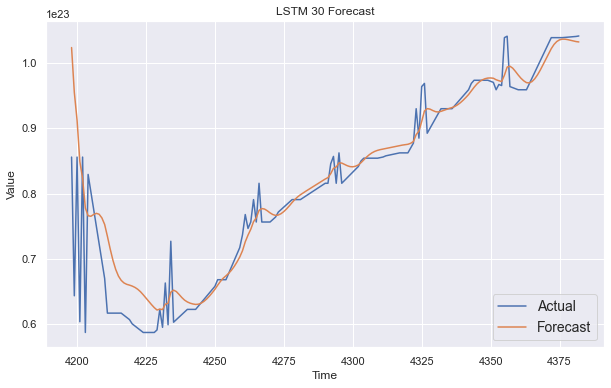

In [219]:
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Hash rate')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plot_series(x_test9.index, x_test9, label="Actual")
plot_series(x_test9.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

In [221]:
# calculate MAE
lstm9 = mean_absolute_error(x_test9, rnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['LSTM9'] = lstm9
model_mae_scores

{'naive9': 1.8456794211729917e+21,
 'naive200': 2.814266532653555e+20,
 'ARIMA9': 4.110312337389515e+20,
 'LSTM9': 2.39808143460219e+21}

In [222]:
#ora per MA200
#FIND THE LEARNING RATE
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 20
train_set200 = sequential_window_dataset(normalized_x_train200, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set200, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100


/usr/local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


73/73 [==============================] - 10s 20ms/step - loss: 0.0785 - mae: 0.3057 - lr: 1.0000e-05
Epoch 2/100
73/73 [==============================] - 1s 17ms/step - loss: 0.0509 - mae: 0.2415 - lr: 1.1220e-05
Epoch 3/100
73/73 [==============================] - 1s 15ms/step - loss: 0.0260 - mae: 0.1769 - lr: 1.2589e-05
Epoch 4/100
73/73 [==============================] - 1s 18ms/step - loss: 0.0067 - mae: 0.0980 - lr: 1.4125e-05
Epoch 5/100
73/73 [==============================] - 1s 18ms/step - loss: 0.0014 - mae: 0.0429 - lr: 1.5849e-05
Epoch 6/100
73/73 [==============================] - 2s 20ms/step - loss: 0.0012 - mae: 0.0380 - lr: 1.7783e-05
Epoch 7/100
73/73 [==============================] - 1s 17ms/step - loss: 9.8660e-04 - mae: 0.0334 - lr: 1.9953e-05
Epoch 8/100
73/73 [==============================] - 1s 16ms/step - loss: 7.8872e-04 - mae: 0.0296 - lr: 2.2387e-05
Epoch 9/100
73/73 [==============================] - 1s 17ms/step - loss: 6.2684e-04 - mae: 0.0268 - lr: 2.

73/73 [==============================] - 1s 13ms/step - loss: 0.0081 - mae: 0.0406 - lr: 0.0398
Epoch 74/100
73/73 [==============================] - 1s 13ms/step - loss: 0.0086 - mae: 0.0663 - lr: 0.0447
Epoch 75/100
73/73 [==============================] - 1s 14ms/step - loss: 0.0145 - mae: 0.0440 - lr: 0.0501
Epoch 76/100
73/73 [==============================] - 1s 15ms/step - loss: 0.0167 - mae: 0.0555 - lr: 0.0562
Epoch 77/100
73/73 [==============================] - 1s 15ms/step - loss: 0.0115 - mae: 0.0450 - lr: 0.0631
Epoch 78/100
73/73 [==============================] - 1s 14ms/step - loss: 0.0186 - mae: 0.0466 - lr: 0.0708
Epoch 79/100
73/73 [==============================] - 1s 13ms/step - loss: 1.6197 - mae: 2.1132 - lr: 0.0794
Epoch 80/100
73/73 [==============================] - 1s 12ms/step - loss: 0.2855 - mae: 0.5370 - lr: 0.0891
Epoch 81/100
73/73 [==============================] - 1s 12ms/step - loss: 0.1559 - mae: 0.3925 - lr: 0.1000
Epoch 82/100
73/73 [============

In [223]:
#This is the best learning rate
history.history["loss"][history.history["loss"].index(min(history.history["loss"]))]
#Arrotondo a 2.67e-5

3.366474629729055e-05

In [226]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 30
train_set = sequential_window_dataset(normalized_x_train200, window_size)
valid_set = sequential_window_dataset(normalized_x_valid200, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.Nadam(lr=2.67e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

#set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(train_set200, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
     71/Unknown - 13s 26ms/step - loss: 0.0227 - mae: 0.1758

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


73/73 [==============================] - 72s 845ms/step - loss: 0.0224 - mae: 0.1756 - val_loss: 0.0131 - val_mae: 0.1612
Epoch 2/500
73/73 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0408

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


73/73 [==============================] - 33s 451ms/step - loss: 0.0013 - mae: 0.0408 - val_loss: 1.8792e-04 - val_mae: 0.0172
Epoch 3/500
71/73 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0358

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


73/73 [==============================] - 27s 380ms/step - loss: 0.0010 - mae: 0.0349 - val_loss: 1.1571e-04 - val_mae: 0.0127
Epoch 4/500
70/73 [===========================>..] - ETA: 0s - loss: 6.7744e-04 - mae: 0.0281

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


73/73 [==============================] - 30s 420ms/step - loss: 6.5052e-04 - mae: 0.0272 - val_loss: 9.2207e-05 - val_mae: 0.0110
Epoch 5/500
69/73 [===========================>..] - ETA: 0s - loss: 4.4140e-04 - mae: 0.0226

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


73/73 [==============================] - 34s 476ms/step - loss: 4.1860e-04 - mae: 0.0216 - val_loss: 8.4429e-05 - val_mae: 0.0104
Epoch 6/500
73/73 [==============================] - ETA: 0s - loss: 2.8129e-04 - mae: 0.0180

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


73/73 [==============================] - 38s 527ms/step - loss: 2.8129e-04 - mae: 0.0180 - val_loss: 8.0315e-05 - val_mae: 0.0100
Epoch 7/500
71/73 [============================>.] - ETA: 0s - loss: 2.0648e-04 - mae: 0.0159

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


73/73 [==============================] - 42s 589ms/step - loss: 2.0142e-04 - mae: 0.0156 - val_loss: 7.7509e-05 - val_mae: 0.0098
Epoch 8/500
71/73 [============================>.] - ETA: 0s - loss: 1.5810e-04 - mae: 0.0142

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


73/73 [==============================] - 38s 533ms/step - loss: 1.5438e-04 - mae: 0.0139 - val_loss: 7.5769e-05 - val_mae: 0.0096
Epoch 9/500
71/73 [============================>.] - ETA: 0s - loss: 1.2861e-04 - mae: 0.0129

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


73/73 [==============================] - 34s 472ms/step - loss: 1.2569e-04 - mae: 0.0127 - val_loss: 7.5110e-05 - val_mae: 0.0095
Epoch 10/500
73/73 [==============================] - 3s 42ms/step - loss: 1.0728e-04 - mae: 0.0118 - val_loss: 7.5438e-05 - val_mae: 0.0095
Epoch 11/500
73/73 [==============================] - 1s 20ms/step - loss: 9.4757e-05 - mae: 0.0111 - val_loss: 7.6594e-05 - val_mae: 0.0096
Epoch 12/500
73/73 [==============================] - 1s 20ms/step - loss: 8.5739e-05 - mae: 0.0106 - val_loss: 7.8399e-05 - val_mae: 0.0098
Epoch 13/500
73/73 [==============================] - 1s 16ms/step - loss: 7.8924e-05 - mae: 0.0102 - val_loss: 8.0703e-05 - val_mae: 0.0100
Epoch 14/500
73/73 [==============================] - 1s 17ms/step - loss: 7.3580e-05 - mae: 0.0099 - val_loss: 8.3380e-05 - val_mae: 0.0102
Epoch 15/500
73/73 [==============================] - 1s 19ms/step - loss: 6.9278e-05 - mae: 0.0096 - val_loss: 8.6340e-05 - val_mae: 0.0104
Epoch 16/500
73/73 [====

1/1 [==============================] - 3s 3s/step


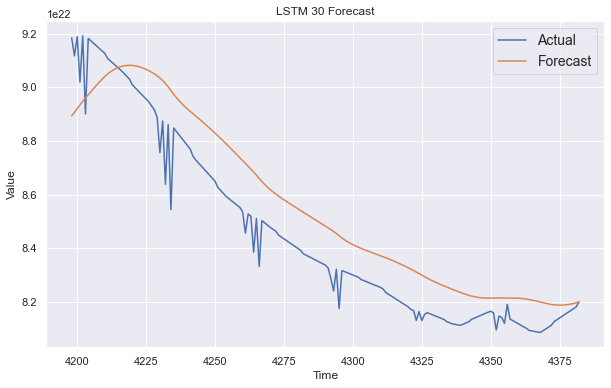

{'naive9': 1.8456794211729917e+21,
 'naive200': 2.814266532653555e+20,
 'ARIMA9': 4.110312337389515e+20,
 'LSTM9': 2.39808143460219e+21,
 'LSTM200': 1.301131540210083e+21}

In [227]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
rnn_forecast200 = model.predict(normalized_x_test200[np.newaxis,:])
rnn_forecast200 = rnn_forecast200.flatten()
# Example of how to iverse
rnn_unscaled_forecast200 = x_train200_scaler.inverse_transform(rnn_forecast200.reshape(-1,1)).flatten()
rnn_unscaled_forecast200.shape

# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Difficulty Ribbon MA200')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plot_series(x_test200.index, x_test200, label="Actual")
plot_series(x_test200.index, rnn_unscaled_forecast200, label="Forecast")
plt.show()

# calculate MAE
lstm200 = mean_absolute_error(x_test200, rnn_unscaled_forecast200)

# Save to our dictionary of model mae scores
model_mae_scores['LSTM200'] = lstm200
model_mae_scores

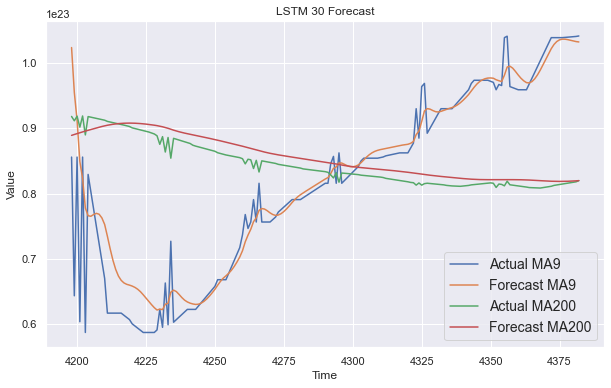

In [230]:
#PLOTTO INSIEME
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Hash rate')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plot_series(x_test9.index, x_test9, label="Actual MA9")
plot_series(x_test9.index, rnn_unscaled_forecast, label="Forecast MA9")
plot_series(x_test200.index, x_test200, label="Actual MA200")
plot_series(x_test200.index, rnn_unscaled_forecast200, label="Forecast MA200")
plt.show()

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

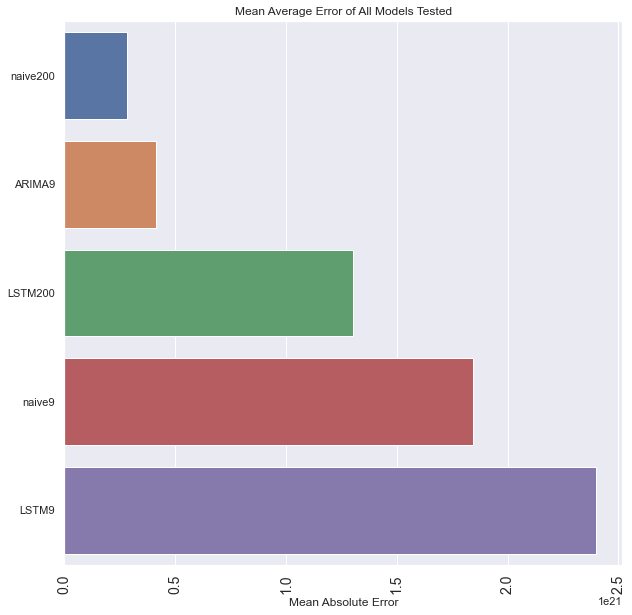

In [231]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')

# CNN

Full CNNs are becoming more commom to detect trends in NLP and time series modeling. A popular architecture is the WaveNet architecture proposed by Deep Mind in 2016.

In WaveNet, every layer has kernel size 2, stride 1, causal padding, and using ReLU activation functions. However, the 2nd layer uses a dilation rate of 2. This means it skips every other input timestep. The next layer uses a dilation rate of 4 which means it skips every 3 input time steps. The fourth layer uses a dilation rate of 8 which means it skips every 7 timesteps out of 8. This patter continues which enables the lower layers to learn shorter term patterns while the deeper layers learn the longer term patterns.

The last layer acts as a dense layer to output a single value.

In [232]:
def seq2seq_window_dataset(series, window_size, batch_size=128,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### Find the learning rate

In [233]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set9 = seq2seq_window_dataset(normalized_x_train9, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Nadam(lr=1e-4)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set9, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


12/12 [==============================] - 6s 73ms/step - loss: 0.1202 - mae: 0.3802 - lr: 1.0000e-04
Epoch 2/100
12/12 [==============================] - 1s 31ms/step - loss: 0.1150 - mae: 0.3698 - lr: 1.0798e-04
Epoch 3/100
12/12 [==============================] - 1s 43ms/step - loss: 0.1092 - mae: 0.3583 - lr: 1.1659e-04
Epoch 4/100
12/12 [==============================] - 1s 40ms/step - loss: 0.1020 - mae: 0.3447 - lr: 1.2589e-04
Epoch 5/100
12/12 [==============================] - 1s 39ms/step - loss: 0.0934 - mae: 0.3288 - lr: 1.3594e-04
Epoch 6/100
12/12 [==============================] - 1s 41ms/step - loss: 0.0825 - mae: 0.3080 - lr: 1.4678e-04
Epoch 7/100
12/12 [==============================] - 1s 38ms/step - loss: 0.0683 - mae: 0.2801 - lr: 1.5849e-04
Epoch 8/100
12/12 [==============================] - 1s 39ms/step - loss: 0.0508 - mae: 0.2401 - lr: 1.7113e-04
Epoch 9/100
12/12 [==============================] - 1s 42ms/step - loss: 0.0334 - mae: 0.1940 - lr: 1.8478e-04
Epoc

12/12 [==============================] - 1s 40ms/step - loss: 0.0480 - mae: 0.2668 - lr: 0.0271
Epoch 75/100
12/12 [==============================] - 1s 37ms/step - loss: 0.0485 - mae: 0.2701 - lr: 0.0293
Epoch 76/100
12/12 [==============================] - 1s 37ms/step - loss: 0.0482 - mae: 0.2678 - lr: 0.0316
Epoch 77/100
12/12 [==============================] - 1s 35ms/step - loss: 0.0486 - mae: 0.2687 - lr: 0.0341
Epoch 78/100
12/12 [==============================] - 1s 35ms/step - loss: 0.0488 - mae: 0.2692 - lr: 0.0369
Epoch 79/100
12/12 [==============================] - 1s 34ms/step - loss: 0.0483 - mae: 0.2682 - lr: 0.0398
Epoch 80/100
12/12 [==============================] - 1s 33ms/step - loss: 0.0478 - mae: 0.2660 - lr: 0.0430
Epoch 81/100
12/12 [==============================] - 1s 35ms/step - loss: 0.0485 - mae: 0.2698 - lr: 0.0464
Epoch 82/100
12/12 [==============================] - 1s 37ms/step - loss: 0.0478 - mae: 0.2672 - lr: 0.0501
Epoch 83/100
12/12 [============

(0.0001, 0.1, 0.0, 0.04)

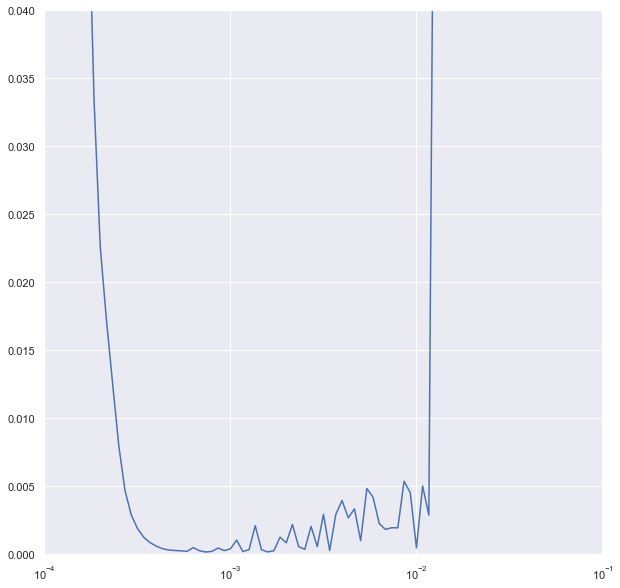

In [234]:
# Plot learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, .04])

In [236]:
#This is the best learning rate
history.history["loss"][history.history["loss"].index(min(history.history["loss"]))]
#Arrotondo a 0.00015 anche qui

0.00015127142251003534

In [237]:
# Clear any background data that may have stored
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Create input sequence batches
window_size = 30
train_set9 = seq2seq_window_dataset(normalized_x_train9, window_size,
                                   batch_size=128)
valid_set9 = seq2seq_window_dataset(normalized_x_valid9, window_size,
                                   batch_size=128)

# Create model object and set up wavenet architecture
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=128,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

# Add final dense layer
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

# Set Nadam as optimizer
optimizer = keras.optimizers.Nadam(lr=0.00015)

# Compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# save best model 
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# sav history
history = model.fit(train_set9, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
12/12 [==============================] - 15s 264ms/step - loss: 0.1054 - mae: 0.3554 - val_loss: 0.4689 - val_mae: 0.9670
Epoch 2/500
12/12 [==============================] - 3s 221ms/step - loss: 0.0666 - mae: 0.2771 - val_loss: 0.1935 - val_mae: 0.5963
Epoch 3/500
12/12 [==============================] - 2s 178ms/step - loss: 0.0190 - mae: 0.1404 - val_loss: 0.0606 - val_mae: 0.2615
Epoch 4/500
12/12 [==============================] - 2s 157ms/step - loss: 0.0096 - mae: 0.1036 - val_loss: 0.0329 - val_mae: 0.1658
Epoch 5/500
12/12 [==============================] - 2s 151ms/step - loss: 0.0043 - mae: 0.0626 - val_loss: 0.0135 - val_mae: 0.0810
Epoch 6/500
12/12 [==============================] - 2s 178ms/step - loss: 0.0019 - mae: 0.0369 - val_loss: 0.0068 - val_mae: 0.0527
Epoch 7/500
12/12 [==============================] - 2s 172ms/step - loss: 0.0010 - mae: 0.0275 - val_loss: 0.0039 - val_mae: 0.0438
Epoch 8/500
12/12 [==============================] - 2s 152ms/step -

Epoch 60/500
12/12 [==============================] - 2s 139ms/step - loss: 1.2485e-04 - mae: 0.0092 - val_loss: 5.8773e-04 - val_mae: 0.0329
Epoch 61/500
12/12 [==============================] - 2s 130ms/step - loss: 9.6270e-05 - mae: 0.0076 - val_loss: 2.9298e-04 - val_mae: 0.0221
Epoch 62/500
12/12 [==============================] - 2s 159ms/step - loss: 8.8438e-05 - mae: 0.0069 - val_loss: 2.8761e-04 - val_mae: 0.0222
Epoch 63/500
12/12 [==============================] - 2s 124ms/step - loss: 8.8968e-05 - mae: 0.0069 - val_loss: 2.2324e-04 - val_mae: 0.0188
Epoch 64/500
12/12 [==============================] - 2s 139ms/step - loss: 9.0248e-05 - mae: 0.0070 - val_loss: 5.7525e-05 - val_mae: 0.0056
Epoch 65/500
12/12 [==============================] - 2s 161ms/step - loss: 1.0329e-04 - mae: 0.0078 - val_loss: 9.1273e-04 - val_mae: 0.0409
Epoch 66/500
12/12 [==============================] - 2s 134ms/step - loss: 1.2105e-04 - mae: 0.0093 - val_loss: 6.6281e-04 - val_mae: 0.0349
Epoch 

Epoch 118/500
12/12 [==============================] - 2s 144ms/step - loss: 8.9868e-05 - mae: 0.0071 - val_loss: 5.1200e-04 - val_mae: 0.0306
Epoch 119/500
12/12 [==============================] - 2s 141ms/step - loss: 1.4126e-04 - mae: 0.0099 - val_loss: 0.0016 - val_mae: 0.0530
Epoch 120/500
12/12 [==============================] - 2s 152ms/step - loss: 1.0705e-04 - mae: 0.0084 - val_loss: 4.9315e-04 - val_mae: 0.0299
Epoch 121/500
12/12 [==============================] - 2s 143ms/step - loss: 8.6763e-05 - mae: 0.0068 - val_loss: 1.0943e-04 - val_mae: 0.0122
Epoch 122/500
12/12 [==============================] - 2s 132ms/step - loss: 1.5394e-04 - mae: 0.0104 - val_loss: 0.0021 - val_mae: 0.0625
Epoch 123/500
12/12 [==============================] - 2s 154ms/step - loss: 1.4839e-04 - mae: 0.0109 - val_loss: 0.0012 - val_mae: 0.0482
Epoch 124/500
12/12 [==============================] - 2s 154ms/step - loss: 9.4417e-05 - mae: 0.0077 - val_loss: 1.6104e-04 - val_mae: 0.0171
Epoch 125/5

12/12 [==============================] - 2s 140ms/step - loss: 8.4656e-05 - mae: 0.0069 - val_loss: 1.7307e-04 - val_mae: 0.0167
Epoch 176/500
12/12 [==============================] - 2s 136ms/step - loss: 8.3396e-05 - mae: 0.0066 - val_loss: 8.9072e-05 - val_mae: 0.0108
Epoch 177/500
12/12 [==============================] - 2s 155ms/step - loss: 8.1662e-05 - mae: 0.0064 - val_loss: 9.3612e-05 - val_mae: 0.0113
Epoch 178/500
12/12 [==============================] - 2s 121ms/step - loss: 8.3976e-05 - mae: 0.0066 - val_loss: 2.5841e-04 - val_mae: 0.0212
Epoch 179/500
12/12 [==============================] - 2s 122ms/step - loss: 8.2109e-05 - mae: 0.0065 - val_loss: 1.3918e-04 - val_mae: 0.0142
Epoch 180/500
12/12 [==============================] - 2s 136ms/step - loss: 1.0909e-04 - mae: 0.0082 - val_loss: 0.0027 - val_mae: 0.0702
Epoch 181/500
12/12 [==============================] - 2s 127ms/step - loss: 1.3178e-04 - mae: 0.0101 - val_loss: 0.0017 - val_mae: 0.0567
Epoch 182/500
12/12 [

12/12 [==============================] - 2s 126ms/step - loss: 9.4098e-05 - mae: 0.0077 - val_loss: 2.0279e-04 - val_mae: 0.0185
Epoch 233/500
12/12 [==============================] - 2s 120ms/step - loss: 1.0812e-04 - mae: 0.0085 - val_loss: 1.9654e-04 - val_mae: 0.0192
Epoch 234/500
12/12 [==============================] - 2s 132ms/step - loss: 1.1363e-04 - mae: 0.0090 - val_loss: 2.2316e-04 - val_mae: 0.0196
Epoch 235/500
12/12 [==============================] - 2s 119ms/step - loss: 8.5672e-05 - mae: 0.0070 - val_loss: 4.0486e-04 - val_mae: 0.0272
Epoch 236/500
12/12 [==============================] - 2s 123ms/step - loss: 9.7613e-05 - mae: 0.0079 - val_loss: 4.8804e-04 - val_mae: 0.0299


In [238]:
# reload best model checkpoint
model = keras.models.load_model("my_checkpoint.h5")

In [242]:
# Use best model to get forecasts
cnn_forecast9 = model_forecast(model, spy_normalized_to_traindata9[:,  np.newaxis], window_size)
cnn_forecast9 = cnn_forecast9[x_test9.index.min() - window_size:-1,-1,0]
# Scale back to normal
cnn_unscaled_forecast = x_train9_scaler.inverse_transform(cnn_forecast9.reshape(-1,1)).flatten()
cnn_unscaled_forecast.shape

57/57 [==============================] - 1s 23ms/step


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

NameError: name 'cnn_unscaled_forecast' is not defined

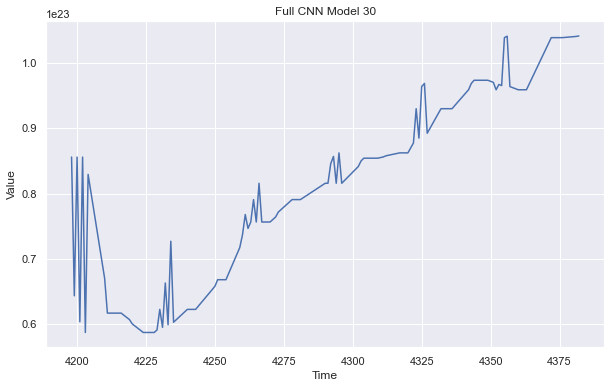

In [239]:
# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('Hash rate')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plot_series(x_test9.index, x_test9)
plot_series(x_test9.index, cnn_unscaled_forecast)

In [168]:
# Calculate MAE
cnn9 = mean_absolute_error(x_test9, cnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['CNN'] = cnn9
model_mae_scores

{'naive': 1.3025434603123286e+19,
 'SMA 20': 1.7718263902870979e+19,
 'SMA 5': 1.0343140678209952e+19,
 'ARIMA': 1.0059460331759155e+19,
 'LSTM': 9.74211815168769e+18,
 'CNN': 1.047393966752586e+19}

In [ ]:
#ora per 200
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set200 = seq2seq_window_dataset(normalized_x_train200, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Nadam(lr=1e-4)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set200, epochs=100, callbacks=[lr_schedule])

In [ ]:
# Plot learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, .04])

In [ ]:
#This is the best learning rate
history.history["loss"][history.history["loss"].index(min(history.history["loss"]))]
#Arrotondo a 0.00015 anche qui

In [ ]:
# Clear any background data that may have stored
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Create input sequence batches
window_size = 30
train_set200 = seq2seq_window_dataset(normalized_x_train200, window_size,
                                   batch_size=128)
valid_set200 = seq2seq_window_dataset(normalized_x_valid200, window_size,
                                   batch_size=128)

# Create model object and set up wavenet architecture
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=128,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

# Add final dense layer
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

# Set Nadam as optimizer
optimizer = keras.optimizers.Nadam(lr=0.00015)

# Compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# save best model 
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# sav history
history = model.fit(train_set200, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

In [ ]:
# reload best model checkpoint
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
# Use best model to get forecasts
cnn_forecast200 = model_forecast(model, spy_normalized_to_traindata[:,  np.newaxis], window_size)
cnn_forecast200 = cnn_forecast200[x_test200.index.min() - window_size:-1,-1,0]
# Scale back to normal
cnn_unscaled_forecast200 = x_train200_scaler.inverse_transform(cnn_forecast200.reshape(-1,1)).flatten()
cnn_unscaled_forecast200.shape

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('Difficulty Ribbon')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plot_series(x_test200.index, x_test200)
plot_series(x_test200.index, cnn_unscaled_forecast200)

In [ ]:
# Calculate MAE
cnn200 = mean_absolute_error(x_test200, cnn_unscaled_forecast200)

# Save to our dictionary of model mae scores
model_mae_scores['CNN'] = cnn200
model_mae_scores

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

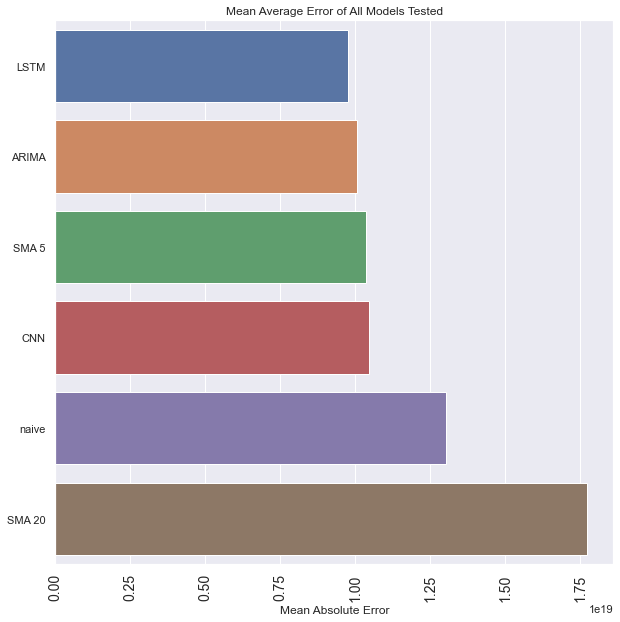

In [169]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')